In [ ]:
# Virtual env name is "xray"
# "source activate xray" should be called

In [180]:
import torch, torchvision

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from tqdm import tqdm
import time
import copy
import shutil
from collections import defaultdict
import albumentations as A

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn off scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 4299
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [52]:
import pathlib
data_dir = pathlib.Path('/Users/serdar/DATASETS/chest_XRay')

In [123]:
class_names = []
for class_name in list(data_dir.glob('*/*/')):
    class_name = str(class_name).split('/')[-1]
    if class_name != '.DS_Store':
        class_names.append(class_name)
class_names = set(class_names)
CLASS_NAMES = list(class_names)
CLASS_NAMES

['PNEUMONIA', 'NORMAL']

In [122]:
image_count = len(list(data_dir.glob('*/*/*.jpeg')))
print('Total Image Count :', image_count)

Total Image Count : 5856


In [118]:
path = '/Users/serdar/DATASETS/chest_XRay/*'

for folder in glob(path):
    subfolder_name = folder.split('/')[-1]
    print("Main Folder :", subfolder_name.upper())
    #print("folder name :", subfolder_name, "&&", "# of documents :", len(os.listdir(folder)))
    for sub_f in glob(folder+'/*'):
        sub_f2 = sub_f.split('/')[-1] 
        print(f"  {sub_f2:<10} image number: {len(os.listdir(sub_f))}")
    print()

Main Folder : TEST
  PNEUMONIA  image number: 390
  NORMAL     image number: 234

Main Folder : TRAIN
  PNEUMONIA  image number: 3875
  NORMAL     image number: 1341

Main Folder : VAL
  PNEUMONIA  image number: 8
  NORMAL     image number: 8



In [119]:
# As we can see here we have imbalanced dataset
# We'll use "albumentations" package for data augmentation for training set

In [120]:
def show_image(img_path):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')

In [121]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    if resize:
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    return img

In [172]:
def show_xray_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    # Open CV uses np array so we need to convert them to Tensors
    images = torch.as_tensor(images)

    # we will permute the color chnanels (permute sirasini degisitmek)
    # Daha once load_image icinde zaten RGB formatina gecmistik
    # burada color channel'i (3) one aliyoruz, (0) batch, (1) height, (2) width
    images = images.permute(0, 3, 1, 2)
    
    # we want 11 images side by side
    grid_img = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize=(16,8))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

In [173]:
train_folders = sorted(glob(path))

In [174]:
train_folders

['/Users/serdar/DATASETS/chest_XRay/test',
 '/Users/serdar/DATASETS/chest_XRay/train',
 '/Users/serdar/DATASETS/chest_XRay/val']

In [175]:
sample_images = [np.random.choice(glob(f'{tf}/*/*jpeg'), size=5) for tf in train_folders]

In [176]:
from itertools import chain
sample_images = list(chain.from_iterable(sample_images))                

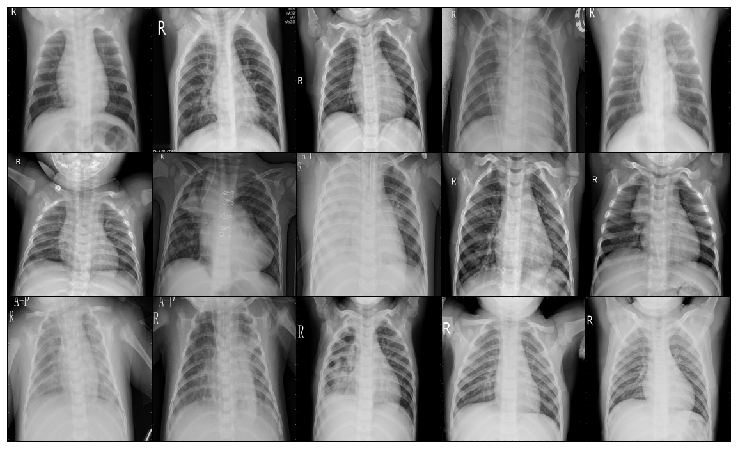

In [177]:
show_xray_grid(sample_images)

### Data Augmentation

In [181]:
doc_aug = A.Compose([
                     A.Flip(p=0.25),
                     A.RandomGamma(gamma_limit=(20,300)),
                     A.RandomBrightnessContrast(p=0.85),
                     A.Rotate(limit=0.35, p=0.9),
                     A.RandomRotate90(p=0.9),
                     A.RGBShift(p=0.75),
                     A.GaussNoise(p=0.25)])

Image to be augmented is  /Users/serdar/DATASETS/chest_XRay/train/NORMAL/IM-0605-0001.jpeg


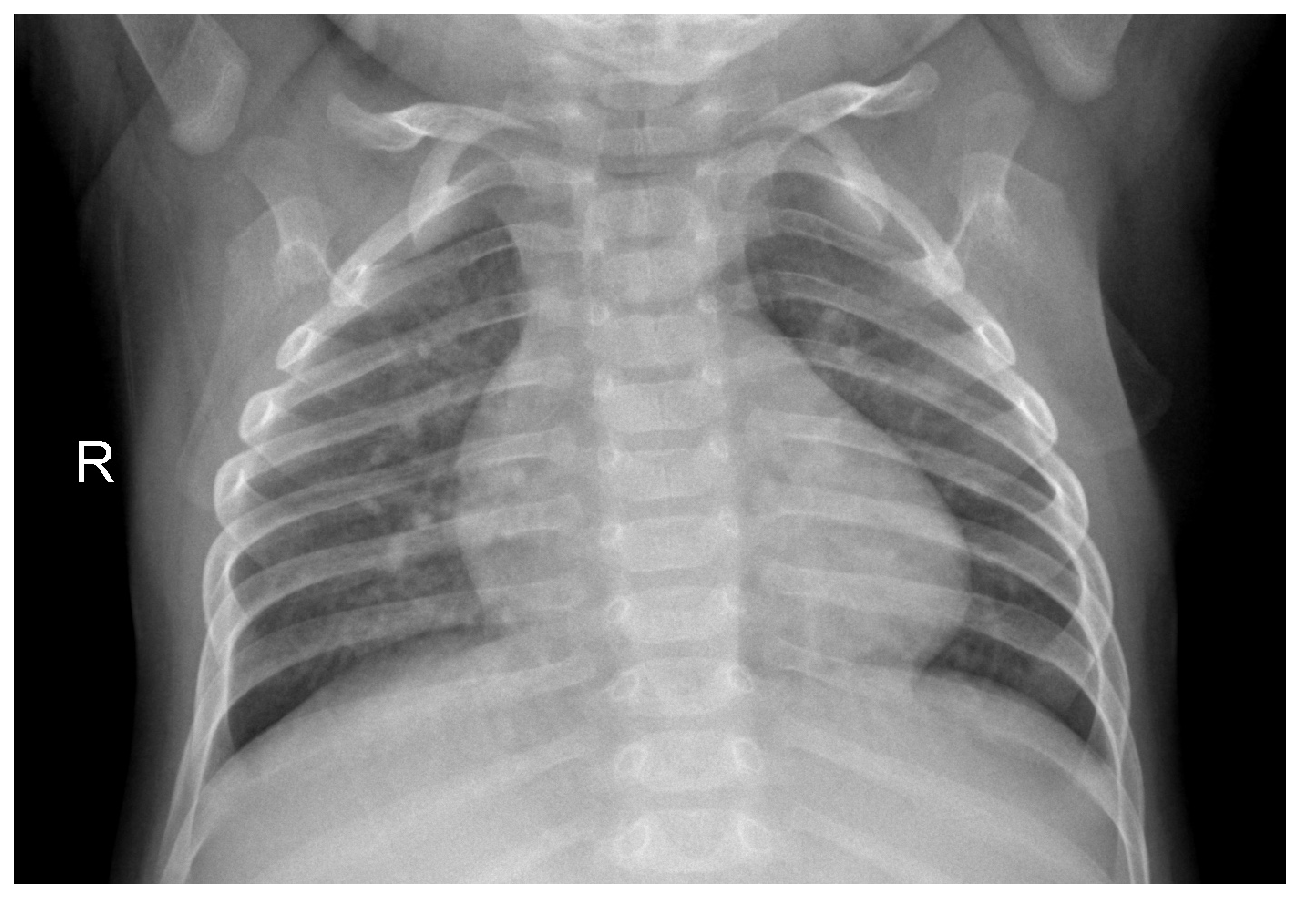

In [197]:
img_to_be_augmented = glob(f'{train_folders[1]}/NORMAL/*jpeg')[33]
print('Image to be augmented is ', img_to_be_augmented)
show_image(img_to_be_augmented)

In [201]:
img_to_be_augmented = cv2.cvtColor(cv2.imread(img_to_be_augmented), cv2.COLOR_BGR2RGB)

In [202]:
# Path for normal in train set
Augmented_TrainNormal_Path = '/Users/serdar/DATASETS/chest_XRay/train/augmented'  
os.makedirs(Augmented_TrainNormal_Path, exist_ok=True)

In [203]:
3875-1341

2534

In [204]:
# 2534 images needed to be balanced the train dataset
for i in tqdm(range(2534)):
    augmented = doc_aug(image=img_to_be_augmented)
    file_name = f'normal_aug_{i}.jpeg'
    cv2.imwrite(f'{Augmented_TrainNormal_Path}/{file_name}', augmented['image'])

  0%|          | 0/2534 [00:00<?, ?it/s]

True

True

  0%|          | 2/2534 [00:00<07:27,  5.65it/s]

True

True

  0%|          | 4/2534 [00:00<07:03,  5.97it/s]

True

True

  0%|          | 6/2534 [00:00<05:58,  7.05it/s]

True

True

  0%|          | 8/2534 [00:00<05:10,  8.14it/s]

True

True

  0%|          | 10/2534 [00:01<04:34,  9.20it/s]

True

  0%|          | 11/2534 [00:01<04:39,  9.01it/s]

True

True

  1%|          | 13/2534 [00:01<04:13,  9.96it/s]

True

True

  1%|          | 15/2534 [00:01<03:57, 10.62it/s]

True

True

  1%|          | 17/2534 [00:01<04:26,  9.44it/s]

True

True

  1%|          | 19/2534 [00:01<03:58, 10.53it/s]

True

True

  1%|          | 21/2534 [00:02<03:40, 11.39it/s]

True

True

  1%|          | 23/2534 [00:02<04:26,  9.41it/s]

True

True

  1%|          | 25/2534 [00:02<04:52,  8.56it/s]

True

True

  1%|          | 27/2534 [00:02<04:25,  9.45it/s]

True

True

  1%|          | 29/2534 [00:02<04:03, 10.27it/s]

True

True

  1%|          | 31/2534 [00:03<03:44, 11.15it/s]

True

True

  1%|▏         | 33/2534 [00:03<03:31, 11.83it/s]

True

True

  1%|▏         | 35/2534 [00:03<03:24, 12.25it/s]

True

True

  1%|▏         | 37/2534 [00:03<03:22, 12.31it/s]

True

True

  2%|▏         | 39/2534 [00:03<03:25, 12.17it/s]

True

True

  2%|▏         | 41/2534 [00:03<03:17, 12.63it/s]

True

True

  2%|▏         | 43/2534 [00:04<03:10, 13.10it/s]

True

True

  2%|▏         | 45/2534 [00:04<04:36,  8.99it/s]

True

True

  2%|▏         | 47/2534 [00:04<04:48,  8.62it/s]

True

True

  2%|▏         | 49/2534 [00:04<04:09,  9.95it/s]

True

True

  2%|▏         | 51/2534 [00:05<04:34,  9.06it/s]

True

True

  2%|▏         | 53/2534 [00:05<04:49,  8.56it/s]

True

  2%|▏         | 54/2534 [00:05<05:55,  6.98it/s]

True

True

  2%|▏         | 56/2534 [00:05<04:57,  8.34it/s]

True

True

  2%|▏         | 58/2534 [00:06<05:41,  7.26it/s]

True

True

True

  2%|▏         | 61/2534 [00:06<04:38,  8.88it/s]

True

True

  2%|▏         | 63/2534 [00:06<03:59, 10.32it/s]

True

True

  3%|▎         | 65/2534 [00:06<04:30,  9.12it/s]

True

True

  3%|▎         | 67/2534 [00:06<03:55, 10.48it/s]

True

True

  3%|▎         | 69/2534 [00:06<04:14,  9.70it/s]

True

True

  3%|▎         | 71/2534 [00:07<03:42, 11.09it/s]

True

True

  3%|▎         | 73/2534 [00:07<04:10,  9.83it/s]

True

True

  3%|▎         | 75/2534 [00:07<03:33, 11.50it/s]

True

True

  3%|▎         | 77/2534 [00:07<03:23, 12.05it/s]

True

True

  3%|▎         | 79/2534 [00:07<03:12, 12.73it/s]

True

True

  3%|▎         | 81/2534 [00:07<03:13, 12.69it/s]

True

True

  3%|▎         | 83/2534 [00:08<04:37,  8.84it/s]

True

True

  3%|▎         | 85/2534 [00:08<05:30,  7.40it/s]

True

True

  3%|▎         | 87/2534 [00:08<05:31,  7.39it/s]

True

True

  4%|▎         | 89/2534 [00:09<04:51,  8.38it/s]

True

  4%|▎         | 90/2534 [00:09<06:01,  6.76it/s]

True

  4%|▎         | 91/2534 [00:09<06:55,  5.88it/s]

True

  4%|▎         | 92/2534 [00:09<07:32,  5.40it/s]

True

True

  4%|▎         | 94/2534 [00:10<07:00,  5.81it/s]

True

True

  4%|▍         | 96/2534 [00:10<06:39,  6.11it/s]

True

True

  4%|▍         | 98/2534 [00:10<05:35,  7.26it/s]

True

True

  4%|▍         | 100/2534 [00:10<04:51,  8.34it/s]

True

True

  4%|▍         | 102/2534 [00:10<05:04,  8.00it/s]

True

True

  4%|▍         | 104/2534 [00:11<04:59,  8.12it/s]

True

True

  4%|▍         | 106/2534 [00:11<04:23,  9.20it/s]

True

True

  4%|▍         | 108/2534 [00:11<04:06,  9.85it/s]

True

True

  4%|▍         | 110/2534 [00:11<03:42, 10.89it/s]

True

True

  4%|▍         | 112/2534 [00:11<03:32, 11.42it/s]

True

True

  4%|▍         | 114/2534 [00:12<04:01, 10.00it/s]

True

True

  5%|▍         | 116/2534 [00:12<03:45, 10.70it/s]

True

True

  5%|▍         | 118/2534 [00:12<03:38, 11.05it/s]

True

True

  5%|▍         | 120/2534 [00:12<03:27, 11.65it/s]

True

True

  5%|▍         | 122/2534 [00:12<03:19, 12.06it/s]

True

True

  5%|▍         | 124/2534 [00:12<03:51, 10.40it/s]

True

True

  5%|▍         | 126/2534 [00:13<03:32, 11.32it/s]

True

True

  5%|▌         | 128/2534 [00:13<03:58, 10.09it/s]

True

True

  5%|▌         | 130/2534 [00:13<04:24,  9.07it/s]

True

True

  5%|▌         | 132/2534 [00:13<03:53, 10.27it/s]

True

True

  5%|▌         | 134/2534 [00:13<04:19,  9.26it/s]

True

True

  5%|▌         | 136/2534 [00:14<05:29,  7.27it/s]

True

True

  5%|▌         | 138/2534 [00:14<04:43,  8.47it/s]

True

True

  6%|▌         | 140/2534 [00:14<04:10,  9.56it/s]

True

True

  6%|▌         | 142/2534 [00:14<04:30,  8.84it/s]

True

True

  6%|▌         | 144/2534 [00:15<04:47,  8.32it/s]

True

True

  6%|▌         | 146/2534 [00:15<04:55,  8.08it/s]

True

True

  6%|▌         | 148/2534 [00:15<04:12,  9.44it/s]

True

True

  6%|▌         | 150/2534 [00:15<03:45, 10.59it/s]

True

True

  6%|▌         | 152/2534 [00:16<04:20,  9.14it/s]

True

True

  6%|▌         | 154/2534 [00:16<03:51, 10.28it/s]

True

True

  6%|▌         | 156/2534 [00:16<03:38, 10.89it/s]

True

True

  6%|▌         | 158/2534 [00:16<04:14,  9.32it/s]

True

True

  6%|▋         | 160/2534 [00:16<03:49, 10.32it/s]

True

True

  6%|▋         | 162/2534 [00:17<05:15,  7.51it/s]

True

True

  6%|▋         | 164/2534 [00:17<04:28,  8.82it/s]

True

True

  7%|▋         | 166/2534 [00:17<04:01,  9.82it/s]

True

True

  7%|▋         | 168/2534 [00:17<03:39, 10.79it/s]

True

True

  7%|▋         | 170/2534 [00:17<04:08,  9.51it/s]

True

True

  7%|▋         | 172/2534 [00:17<03:39, 10.77it/s]

True

True

  7%|▋         | 174/2534 [00:18<03:20, 11.80it/s]

True

True

  7%|▋         | 176/2534 [00:18<04:08,  9.48it/s]

True

True

  7%|▋         | 178/2534 [00:18<03:48, 10.30it/s]

True

True

  7%|▋         | 180/2534 [00:18<03:29, 11.26it/s]

True

True

  7%|▋         | 182/2534 [00:19<04:12,  9.33it/s]

True

True

  7%|▋         | 184/2534 [00:19<04:37,  8.47it/s]

True

True

  7%|▋         | 186/2534 [00:19<04:09,  9.40it/s]

True

True

  7%|▋         | 188/2534 [00:19<04:28,  8.74it/s]

True

True

  7%|▋         | 190/2534 [00:19<03:54, 10.01it/s]

True

True

  8%|▊         | 192/2534 [00:20<04:16,  9.15it/s]

True

True

  8%|▊         | 194/2534 [00:20<03:46, 10.31it/s]

True

True

  8%|▊         | 196/2534 [00:20<03:25, 11.38it/s]

True

True

  8%|▊         | 198/2534 [00:20<03:09, 12.34it/s]

True

True

  8%|▊         | 200/2534 [00:20<04:35,  8.48it/s]

True

True

  8%|▊         | 202/2534 [00:21<04:02,  9.63it/s]

True

True

  8%|▊         | 204/2534 [00:21<04:06,  9.45it/s]

True

True

  8%|▊         | 206/2534 [00:21<04:29,  8.63it/s]

True

  8%|▊         | 207/2534 [00:21<05:23,  7.19it/s]

True

True

  8%|▊         | 209/2534 [00:21<04:29,  8.62it/s]

True

True

  8%|▊         | 211/2534 [00:22<03:45, 10.32it/s]

True

True

  8%|▊         | 213/2534 [00:22<04:21,  8.89it/s]

True

True

  8%|▊         | 215/2534 [00:22<03:53,  9.95it/s]

True

True

  9%|▊         | 217/2534 [00:22<03:41, 10.45it/s]

True

True

  9%|▊         | 219/2534 [00:22<04:16,  9.02it/s]

True

True

  9%|▊         | 221/2534 [00:23<04:30,  8.54it/s]

True

True

  9%|▉         | 223/2534 [00:23<04:38,  8.30it/s]

True

True

  9%|▉         | 225/2534 [00:23<04:09,  9.26it/s]

True

True

  9%|▉         | 227/2534 [00:23<04:28,  8.60it/s]

True

True

  9%|▉         | 229/2534 [00:24<04:28,  8.59it/s]

True

True

  9%|▉         | 231/2534 [00:24<03:57,  9.70it/s]

True

True

  9%|▉         | 233/2534 [00:24<03:36, 10.62it/s]

True

True

  9%|▉         | 235/2534 [00:24<03:21, 11.43it/s]

True

True

  9%|▉         | 237/2534 [00:24<03:54,  9.81it/s]

True

True

  9%|▉         | 239/2534 [00:24<03:30, 10.93it/s]

True

True

 10%|▉         | 241/2534 [00:25<04:48,  7.95it/s]

True

 10%|▉         | 242/2534 [00:25<05:31,  6.92it/s]

True

 10%|▉         | 243/2534 [00:25<05:59,  6.36it/s]

True

True

 10%|▉         | 245/2534 [00:25<05:02,  7.56it/s]

True

True

 10%|▉         | 247/2534 [00:26<04:22,  8.71it/s]

True

True

 10%|▉         | 249/2534 [00:26<03:55,  9.69it/s]

True

True

 10%|▉         | 251/2534 [00:26<04:21,  8.74it/s]

True

True

 10%|▉         | 253/2534 [00:26<04:01,  9.45it/s]

True

True

 10%|█         | 255/2534 [00:26<04:18,  8.82it/s]

True

 10%|█         | 256/2534 [00:27<05:29,  6.91it/s]

True

 10%|█         | 257/2534 [00:27<06:21,  5.97it/s]

True

 10%|█         | 258/2534 [00:27<06:53,  5.50it/s]

True

True

 10%|█         | 260/2534 [00:27<05:28,  6.93it/s]

True

True

 10%|█         | 262/2534 [00:27<04:45,  7.97it/s]

True

True

 10%|█         | 264/2534 [00:27<04:11,  9.02it/s]

True

True

 10%|█         | 266/2534 [00:28<04:44,  7.97it/s]

True

True

 11%|█         | 268/2534 [00:28<04:12,  8.97it/s]

True

True

 11%|█         | 270/2534 [00:28<03:45, 10.02it/s]

True

True

 11%|█         | 272/2534 [00:28<03:20, 11.26it/s]

True

True

 11%|█         | 274/2534 [00:29<04:24,  8.53it/s]

True

True

 11%|█         | 276/2534 [00:29<03:43, 10.12it/s]

True

True

 11%|█         | 278/2534 [00:29<03:20, 11.28it/s]

True

True

 11%|█         | 280/2534 [00:29<03:04, 12.19it/s]

True

True

 11%|█         | 282/2534 [00:29<03:02, 12.36it/s]

True

True

 11%|█         | 284/2534 [00:29<02:54, 12.91it/s]

True

True

 11%|█▏        | 286/2534 [00:30<03:28, 10.78it/s]

True

True

 11%|█▏        | 288/2534 [00:30<04:31,  8.28it/s]

True

True

 11%|█▏        | 290/2534 [00:30<04:42,  7.94it/s]

True

True

 12%|█▏        | 292/2534 [00:30<04:07,  9.06it/s]

True

True

 12%|█▏        | 294/2534 [00:30<03:49,  9.78it/s]

True

True

 12%|█▏        | 296/2534 [00:31<03:36, 10.34it/s]

True

True

 12%|█▏        | 298/2534 [00:31<04:05,  9.09it/s]

True

True

 12%|█▏        | 300/2534 [00:31<03:40, 10.13it/s]

True

True

 12%|█▏        | 302/2534 [00:31<04:45,  7.82it/s]

True

True

 12%|█▏        | 304/2534 [00:32<04:14,  8.78it/s]

True

True

 12%|█▏        | 306/2534 [00:32<03:43,  9.95it/s]

True

True

 12%|█▏        | 308/2534 [00:32<03:15, 11.37it/s]

True

True

 12%|█▏        | 310/2534 [00:32<03:45,  9.88it/s]

True

True

 12%|█▏        | 312/2534 [00:32<04:15,  8.71it/s]

True

True

 12%|█▏        | 314/2534 [00:33<04:44,  7.81it/s]

True

True

 12%|█▏        | 316/2534 [00:33<04:07,  8.94it/s]

True

True

 13%|█▎        | 318/2534 [00:33<04:19,  8.53it/s]

True

True

 13%|█▎        | 320/2534 [00:33<03:43,  9.91it/s]

True

True

 13%|█▎        | 322/2534 [00:33<03:26, 10.70it/s]

True

True

 13%|█▎        | 324/2534 [00:34<03:01, 12.15it/s]

True

True

 13%|█▎        | 326/2534 [00:34<02:50, 12.91it/s]

True

True

 13%|█▎        | 328/2534 [00:34<03:27, 10.61it/s]

True

True

 13%|█▎        | 330/2534 [00:34<03:48,  9.64it/s]

True

True

 13%|█▎        | 332/2534 [00:34<04:07,  8.91it/s]

True

True

 13%|█▎        | 334/2534 [00:35<03:37, 10.11it/s]

True

True

 13%|█▎        | 336/2534 [00:35<03:12, 11.43it/s]

True

True

 13%|█▎        | 338/2534 [00:35<02:50, 12.91it/s]

True

True

 13%|█▎        | 340/2534 [00:35<03:31, 10.37it/s]

True

True

 13%|█▎        | 342/2534 [00:35<03:10, 11.51it/s]

True

True

 14%|█▎        | 344/2534 [00:35<03:31, 10.34it/s]

True

True

 14%|█▎        | 346/2534 [00:36<03:06, 11.72it/s]

True

True

 14%|█▎        | 348/2534 [00:36<03:36, 10.11it/s]

True

True

 14%|█▍        | 350/2534 [00:36<03:15, 11.15it/s]

True

True

 14%|█▍        | 352/2534 [00:36<04:23,  8.27it/s]

True

True

 14%|█▍        | 354/2534 [00:37<05:10,  7.02it/s]

True

True

 14%|█▍        | 356/2534 [00:37<04:59,  7.28it/s]

True

True

 14%|█▍        | 358/2534 [00:37<04:17,  8.46it/s]

True

True

 14%|█▍        | 360/2534 [00:37<03:51,  9.39it/s]

True

True

 14%|█▍        | 362/2534 [00:37<03:25, 10.56it/s]

True

True

 14%|█▍        | 364/2534 [00:38<03:08, 11.53it/s]

True

True

 14%|█▍        | 366/2534 [00:38<02:59, 12.05it/s]

True

True

True

 15%|█▍        | 369/2534 [00:38<02:42, 13.31it/s]

True

True

 15%|█▍        | 371/2534 [00:38<03:56,  9.15it/s]

True

True

 15%|█▍        | 373/2534 [00:38<03:32, 10.18it/s]

True

True

 15%|█▍        | 375/2534 [00:39<03:58,  9.06it/s]

True

True

 15%|█▍        | 377/2534 [00:39<03:23, 10.61it/s]

True

True

 15%|█▍        | 379/2534 [00:39<03:01, 11.88it/s]

True

True

 15%|█▌        | 381/2534 [00:39<02:47, 12.84it/s]

True

True

 15%|█▌        | 383/2534 [00:39<03:15, 10.98it/s]

True

True

 15%|█▌        | 385/2534 [00:39<02:55, 12.22it/s]

True

True

 15%|█▌        | 387/2534 [00:40<03:25, 10.46it/s]

True

True

 15%|█▌        | 389/2534 [00:40<03:51,  9.25it/s]

True

True

 15%|█▌        | 391/2534 [00:40<04:12,  8.48it/s]

True

 15%|█▌        | 392/2534 [00:40<05:08,  6.94it/s]

True

 16%|█▌        | 393/2534 [00:41<05:41,  6.27it/s]

True

 16%|█▌        | 394/2534 [00:41<05:57,  5.98it/s]

True

True

 16%|█▌        | 396/2534 [00:41<04:46,  7.46it/s]

True

 16%|█▌        | 397/2534 [00:41<05:25,  6.56it/s]

True

True

True

 16%|█▌        | 400/2534 [00:41<04:20,  8.18it/s]

True

True

 16%|█▌        | 402/2534 [00:41<03:48,  9.32it/s]

True

True

 16%|█▌        | 404/2534 [00:42<04:05,  8.69it/s]

True

True

 16%|█▌        | 406/2534 [00:42<03:37,  9.79it/s]

True

True

 16%|█▌        | 408/2534 [00:42<03:19, 10.65it/s]

True

True

 16%|█▌        | 410/2534 [00:42<04:27,  7.93it/s]

True

True

 16%|█▋        | 412/2534 [00:43<05:11,  6.80it/s]

True

True

 16%|█▋        | 414/2534 [00:43<04:27,  7.92it/s]

True

True

 16%|█▋        | 416/2534 [00:43<04:28,  7.89it/s]

True

True

 16%|█▋        | 418/2534 [00:43<03:50,  9.18it/s]

True

True

 17%|█▋        | 420/2534 [00:44<04:01,  8.76it/s]

True

True

 17%|█▋        | 422/2534 [00:44<04:23,  8.01it/s]

True

True

 17%|█▋        | 424/2534 [00:44<03:57,  8.90it/s]

True

True

 17%|█▋        | 426/2534 [00:44<03:37,  9.70it/s]

True

True

 17%|█▋        | 428/2534 [00:44<03:09, 11.11it/s]

True

True

 17%|█▋        | 430/2534 [00:45<03:06, 11.29it/s]

True

True

 17%|█▋        | 432/2534 [00:45<03:34,  9.82it/s]

True

True

 17%|█▋        | 434/2534 [00:45<04:32,  7.71it/s]

True

 17%|█▋        | 435/2534 [00:45<04:24,  7.95it/s]

True

True

 17%|█▋        | 437/2534 [00:45<03:50,  9.10it/s]

True

True

 17%|█▋        | 439/2534 [00:46<04:14,  8.24it/s]

True

 17%|█▋        | 440/2534 [00:46<04:53,  7.13it/s]

True

True

 17%|█▋        | 442/2534 [00:46<04:12,  8.29it/s]

True

True

 18%|█▊        | 444/2534 [00:46<03:34,  9.74it/s]

True

True

 18%|█▊        | 446/2534 [00:47<04:25,  7.86it/s]

True

 18%|█▊        | 447/2534 [00:47<04:31,  7.69it/s]

True

 18%|█▊        | 448/2534 [00:47<04:35,  7.57it/s]

True

True

 18%|█▊        | 450/2534 [00:47<04:01,  8.62it/s]

True

True

 18%|█▊        | 452/2534 [00:47<03:30,  9.87it/s]

True

True

 18%|█▊        | 454/2534 [00:47<03:08, 11.03it/s]

True

True

 18%|█▊        | 456/2534 [00:47<02:59, 11.57it/s]

True

True

 18%|█▊        | 458/2534 [00:48<02:52, 12.01it/s]

True

True

 18%|█▊        | 460/2534 [00:48<02:45, 12.56it/s]

True

True

 18%|█▊        | 462/2534 [00:48<02:40, 12.92it/s]

True

True

 18%|█▊        | 464/2534 [00:48<04:04,  8.48it/s]

True

True

 18%|█▊        | 466/2534 [00:49<04:07,  8.36it/s]

True

 18%|█▊        | 467/2534 [00:49<04:55,  7.00it/s]

True

 18%|█▊        | 468/2534 [00:49<05:42,  6.03it/s]

True

 19%|█▊        | 469/2534 [00:49<06:46,  5.08it/s]

True

 19%|█▊        | 470/2534 [00:49<05:47,  5.94it/s]

True

True

 19%|█▊        | 472/2534 [00:50<05:42,  6.02it/s]

True

True

 19%|█▊        | 474/2534 [00:50<04:49,  7.11it/s]

True

True

 19%|█▉        | 476/2534 [00:50<04:09,  8.25it/s]

True

 19%|█▉        | 477/2534 [00:50<04:07,  8.30it/s]

True

 19%|█▉        | 478/2534 [00:50<03:56,  8.70it/s]

True

True

 19%|█▉        | 480/2534 [00:50<03:40,  9.33it/s]

True

True

 19%|█▉        | 482/2534 [00:51<03:34,  9.57it/s]

True

True

 19%|█▉        | 484/2534 [00:51<03:30,  9.76it/s]

True

True

 19%|█▉        | 486/2534 [00:51<04:01,  8.47it/s]

True

True

 19%|█▉        | 488/2534 [00:51<03:25,  9.96it/s]

True

True

 19%|█▉        | 490/2534 [00:51<03:04, 11.10it/s]

True

True

 19%|█▉        | 492/2534 [00:51<03:07, 10.88it/s]

True

True

 19%|█▉        | 494/2534 [00:52<03:57,  8.59it/s]

True

True

 20%|█▉        | 496/2534 [00:52<03:37,  9.37it/s]

True

True

 20%|█▉        | 498/2534 [00:52<04:02,  8.41it/s]

True

True

 20%|█▉        | 500/2534 [00:53<04:50,  7.01it/s]

True

 20%|█▉        | 501/2534 [00:53<04:29,  7.55it/s]

True

True

 20%|█▉        | 503/2534 [00:53<03:54,  8.67it/s]

True

 20%|█▉        | 504/2534 [00:53<05:10,  6.54it/s]

True

True

 20%|█▉        | 506/2534 [00:53<04:58,  6.79it/s]

True

True

 20%|██        | 508/2534 [00:54<04:44,  7.11it/s]

True

 20%|██        | 509/2534 [00:54<05:31,  6.10it/s]

True

 20%|██        | 510/2534 [00:54<05:42,  5.92it/s]

True

 20%|██        | 511/2534 [00:54<05:53,  5.72it/s]

True

 20%|██        | 512/2534 [00:54<06:01,  5.59it/s]

True

 20%|██        | 513/2534 [00:55<06:12,  5.43it/s]

True

True

 20%|██        | 515/2534 [00:55<05:42,  5.89it/s]

True

True

 20%|██        | 517/2534 [00:55<04:40,  7.18it/s]

True

 20%|██        | 518/2534 [00:55<05:48,  5.79it/s]

True

True

 21%|██        | 520/2534 [00:55<04:45,  7.04it/s]

True

True

 21%|██        | 522/2534 [00:56<04:53,  6.85it/s]

True

True

 21%|██        | 524/2534 [00:56<04:45,  7.03it/s]

True

True

 21%|██        | 526/2534 [00:56<03:58,  8.43it/s]

True

True

 21%|██        | 528/2534 [00:56<04:06,  8.14it/s]

True

True

 21%|██        | 530/2534 [00:57<03:42,  9.01it/s]

True

True

 21%|██        | 532/2534 [00:57<05:02,  6.61it/s]

True

 21%|██        | 533/2534 [00:57<04:39,  7.16it/s]

True

True

 21%|██        | 535/2534 [00:57<04:01,  8.26it/s]

True

True

 21%|██        | 537/2534 [00:57<03:26,  9.69it/s]

True

True

 21%|██▏       | 539/2534 [00:58<03:36,  9.21it/s]

True

True

 21%|██▏       | 541/2534 [00:58<03:13, 10.29it/s]

True

True

 21%|██▏       | 543/2534 [00:58<03:53,  8.54it/s]

True

True

 22%|██▏       | 545/2534 [00:58<03:23,  9.78it/s]

True

True

 22%|██▏       | 547/2534 [00:59<04:37,  7.16it/s]

True

True

 22%|██▏       | 549/2534 [00:59<03:45,  8.81it/s]

True

True

 22%|██▏       | 551/2534 [00:59<04:06,  8.05it/s]

True

True

 22%|██▏       | 553/2534 [00:59<03:37,  9.10it/s]

True

True

 22%|██▏       | 555/2534 [01:00<03:20,  9.86it/s]

True

True

 22%|██▏       | 557/2534 [01:00<02:59, 11.00it/s]

True

True

 22%|██▏       | 559/2534 [01:00<03:20,  9.83it/s]

True

True

 22%|██▏       | 561/2534 [01:00<03:02, 10.79it/s]

True

True

 22%|██▏       | 563/2534 [01:00<03:48,  8.64it/s]

True

True

 22%|██▏       | 565/2534 [01:01<04:13,  7.78it/s]

True

 22%|██▏       | 566/2534 [01:01<05:38,  5.82it/s]

True

True

 22%|██▏       | 568/2534 [01:01<05:25,  6.05it/s]

True

True

 22%|██▏       | 570/2534 [01:01<04:35,  7.13it/s]

True

True

 23%|██▎       | 572/2534 [01:02<03:59,  8.21it/s]

True

True

 23%|██▎       | 574/2534 [01:02<04:22,  7.46it/s]

True

True

 23%|██▎       | 576/2534 [01:02<03:52,  8.44it/s]

True

 23%|██▎       | 577/2534 [01:02<05:21,  6.09it/s]

True

 23%|██▎       | 578/2534 [01:03<05:54,  5.52it/s]

True

 23%|██▎       | 579/2534 [01:03<06:21,  5.13it/s]

True

True

 23%|██▎       | 581/2534 [01:03<05:45,  5.65it/s]

True

True

 23%|██▎       | 583/2534 [01:03<05:37,  5.78it/s]

True

True

 23%|██▎       | 585/2534 [01:04<04:39,  6.96it/s]

True

True

 23%|██▎       | 587/2534 [01:04<03:57,  8.19it/s]

True

True

 23%|██▎       | 589/2534 [01:04<03:29,  9.31it/s]

True

True

 23%|██▎       | 591/2534 [01:04<03:07, 10.34it/s]

True

True

 23%|██▎       | 593/2534 [01:04<02:48, 11.55it/s]

True

True

 23%|██▎       | 595/2534 [01:04<02:41, 12.01it/s]

True

True

 24%|██▎       | 597/2534 [01:05<03:55,  8.24it/s]

True

True

 24%|██▎       | 599/2534 [01:05<04:54,  6.57it/s]

True

True

 24%|██▎       | 601/2534 [01:05<04:10,  7.71it/s]

True

True

 24%|██▍       | 603/2534 [01:05<03:27,  9.32it/s]

True

True

 24%|██▍       | 605/2534 [01:06<03:52,  8.28it/s]

True

True

 24%|██▍       | 607/2534 [01:06<04:13,  7.59it/s]

True

True

 24%|██▍       | 609/2534 [01:06<03:44,  8.57it/s]

True

True

 24%|██▍       | 611/2534 [01:06<03:26,  9.31it/s]

True

True

 24%|██▍       | 613/2534 [01:07<03:20,  9.60it/s]

True

True

 24%|██▍       | 615/2534 [01:07<03:07, 10.24it/s]

True

True

 24%|██▍       | 617/2534 [01:07<04:01,  7.94it/s]

True

 24%|██▍       | 618/2534 [01:07<05:15,  6.07it/s]

True

 24%|██▍       | 619/2534 [01:08<06:16,  5.09it/s]

True

True

 25%|██▍       | 621/2534 [01:08<05:52,  5.42it/s]

True

True

 25%|██▍       | 623/2534 [01:08<04:57,  6.42it/s]

True

 25%|██▍       | 624/2534 [01:08<05:48,  5.48it/s]

True

True

 25%|██▍       | 626/2534 [01:09<05:37,  5.65it/s]

True

True

 25%|██▍       | 628/2534 [01:09<05:33,  5.72it/s]

True

True

 25%|██▍       | 630/2534 [01:09<04:41,  6.77it/s]

True

 25%|██▍       | 631/2534 [01:09<05:45,  5.50it/s]

True

 25%|██▍       | 632/2534 [01:10<06:16,  5.05it/s]

True

True

 25%|██▌       | 634/2534 [01:10<05:04,  6.23it/s]

True

True

 25%|██▌       | 636/2534 [01:10<04:52,  6.49it/s]

True

True

 25%|██▌       | 638/2534 [01:10<04:39,  6.78it/s]

True

True

 25%|██▌       | 640/2534 [01:10<03:46,  8.35it/s]

True

True

 25%|██▌       | 642/2534 [01:11<03:33,  8.87it/s]

True

True

 25%|██▌       | 644/2534 [01:11<03:44,  8.41it/s]

True

True

 25%|██▌       | 646/2534 [01:11<03:18,  9.52it/s]

True

True

 26%|██▌       | 648/2534 [01:11<02:51, 10.97it/s]

True

True

 26%|██▌       | 650/2534 [01:11<03:21,  9.36it/s]

True

True

 26%|██▌       | 652/2534 [01:12<03:35,  8.74it/s]

True

True

 26%|██▌       | 654/2534 [01:12<03:08,  9.98it/s]

True

True

 26%|██▌       | 656/2534 [01:12<02:52, 10.91it/s]

True

True

 26%|██▌       | 658/2534 [01:12<02:46, 11.27it/s]

True

True

 26%|██▌       | 660/2534 [01:12<02:36, 11.98it/s]

True

True

 26%|██▌       | 662/2534 [01:13<03:07,  9.96it/s]

True

True

 26%|██▌       | 664/2534 [01:13<02:42, 11.50it/s]

True

True

 26%|██▋       | 666/2534 [01:13<02:33, 12.15it/s]

True

True

 26%|██▋       | 668/2534 [01:13<02:27, 12.66it/s]

True

True

 26%|██▋       | 670/2534 [01:13<03:45,  8.27it/s]

True

True

 27%|██▋       | 672/2534 [01:14<03:51,  8.04it/s]

True

 27%|██▋       | 673/2534 [01:14<04:32,  6.82it/s]

True

True

 27%|██▋       | 675/2534 [01:14<04:27,  6.95it/s]

True

True

 27%|██▋       | 677/2534 [01:14<04:20,  7.12it/s]

True

True

 27%|██▋       | 679/2534 [01:15<03:35,  8.61it/s]

True

True

 27%|██▋       | 681/2534 [01:15<03:02, 10.15it/s]

True

True

 27%|██▋       | 683/2534 [01:15<02:41, 11.48it/s]

True

True

 27%|██▋       | 685/2534 [01:15<02:33, 12.03it/s]

True

True

 27%|██▋       | 687/2534 [01:15<02:29, 12.35it/s]

True

True

 27%|██▋       | 689/2534 [01:15<03:01, 10.18it/s]

True

True

 27%|██▋       | 691/2534 [01:16<02:45, 11.13it/s]

True

True

 27%|██▋       | 693/2534 [01:16<03:11,  9.59it/s]

True

True

 27%|██▋       | 695/2534 [01:16<03:31,  8.71it/s]

True

True

 28%|██▊       | 697/2534 [01:16<03:00, 10.18it/s]

True

True

 28%|██▊       | 699/2534 [01:16<03:23,  9.03it/s]

True

True

 28%|██▊       | 701/2534 [01:17<03:43,  8.21it/s]

True

True

 28%|██▊       | 703/2534 [01:17<03:15,  9.35it/s]

True

True

 28%|██▊       | 705/2534 [01:17<03:21,  9.08it/s]

True

True

 28%|██▊       | 707/2534 [01:17<03:30,  8.69it/s]

True

 28%|██▊       | 708/2534 [01:18<04:13,  7.20it/s]

True

True

 28%|██▊       | 710/2534 [01:18<03:32,  8.60it/s]

True

True

 28%|██▊       | 712/2534 [01:18<04:23,  6.91it/s]

True

True

 28%|██▊       | 714/2534 [01:18<04:26,  6.84it/s]

True

 28%|██▊       | 715/2534 [01:19<05:25,  5.59it/s]

True

True

 28%|██▊       | 717/2534 [01:19<04:32,  6.67it/s]

True

True

 28%|██▊       | 719/2534 [01:19<03:42,  8.15it/s]

True

True

 28%|██▊       | 721/2534 [01:19<03:15,  9.25it/s]

True

True

 29%|██▊       | 723/2534 [01:19<03:37,  8.34it/s]

True

True

 29%|██▊       | 725/2534 [01:20<03:08,  9.61it/s]

True

True

 29%|██▊       | 727/2534 [01:20<02:49, 10.69it/s]

True

True

 29%|██▉       | 729/2534 [01:20<02:44, 10.98it/s]

True

True

 29%|██▉       | 731/2534 [01:20<03:25,  8.79it/s]

True

True

 29%|██▉       | 733/2534 [01:20<03:03,  9.82it/s]

True

True

 29%|██▉       | 735/2534 [01:21<03:27,  8.67it/s]

True

True

 29%|██▉       | 737/2534 [01:21<03:42,  8.06it/s]

True

True

 29%|██▉       | 739/2534 [01:21<03:17,  9.07it/s]

True

True

 29%|██▉       | 741/2534 [01:21<03:01,  9.85it/s]

True

True

 29%|██▉       | 743/2534 [01:22<03:24,  8.75it/s]

True

True

 29%|██▉       | 745/2534 [01:22<03:47,  7.87it/s]

True

True

 29%|██▉       | 747/2534 [01:22<03:19,  8.94it/s]

True

True

 30%|██▉       | 749/2534 [01:22<02:57, 10.04it/s]

True

True

 30%|██▉       | 751/2534 [01:22<03:21,  8.85it/s]

True

True

 30%|██▉       | 753/2534 [01:23<03:02,  9.75it/s]

True

True

 30%|██▉       | 755/2534 [01:23<03:26,  8.62it/s]

True

True

 30%|██▉       | 757/2534 [01:23<02:59,  9.89it/s]

True

True

 30%|██▉       | 759/2534 [01:23<04:01,  7.36it/s]

True

 30%|██▉       | 760/2534 [01:24<04:55,  6.00it/s]

True

 30%|███       | 761/2534 [01:24<05:38,  5.24it/s]

True

True

 30%|███       | 763/2534 [01:24<04:35,  6.43it/s]

True

True

 30%|███       | 765/2534 [01:24<03:48,  7.73it/s]

True

True

 30%|███       | 767/2534 [01:24<03:20,  8.81it/s]

True

True

 30%|███       | 769/2534 [01:25<03:31,  8.35it/s]

True

True

 30%|███       | 771/2534 [01:25<03:51,  7.62it/s]

True

True

 31%|███       | 773/2534 [01:25<04:01,  7.28it/s]

True

 31%|███       | 774/2534 [01:25<04:38,  6.32it/s]

True

True

 31%|███       | 776/2534 [01:26<04:30,  6.49it/s]

True

 31%|███       | 777/2534 [01:26<04:51,  6.02it/s]

True

True

 31%|███       | 779/2534 [01:26<03:58,  7.36it/s]

True

True

 31%|███       | 781/2534 [01:26<03:28,  8.39it/s]

True

True

 31%|███       | 783/2534 [01:27<03:37,  8.06it/s]

True

True

 31%|███       | 785/2534 [01:27<03:49,  7.61it/s]

True

 31%|███       | 786/2534 [01:27<04:17,  6.80it/s]

True

True

 31%|███       | 788/2534 [01:27<03:37,  8.04it/s]

True

True

 31%|███       | 790/2534 [01:27<03:07,  9.28it/s]

True

True

 31%|███▏      | 792/2534 [01:27<02:41, 10.76it/s]

True

True

 31%|███▏      | 794/2534 [01:28<03:04,  9.45it/s]

True

True

 31%|███▏      | 796/2534 [01:28<03:23,  8.55it/s]

True

True

 31%|███▏      | 798/2534 [01:28<03:32,  8.17it/s]

True

 32%|███▏      | 799/2534 [01:28<04:10,  6.92it/s]

True

True

 32%|███▏      | 801/2534 [01:29<03:29,  8.25it/s]

True

True

 32%|███▏      | 803/2534 [01:29<03:04,  9.41it/s]

True

True

 32%|███▏      | 805/2534 [01:29<03:24,  8.46it/s]

True

True

 32%|███▏      | 807/2534 [01:29<03:03,  9.43it/s]

True

True

 32%|███▏      | 809/2534 [01:29<02:44, 10.48it/s]

True

True

 32%|███▏      | 811/2534 [01:29<02:36, 11.03it/s]

True

True

 32%|███▏      | 813/2534 [01:30<02:57,  9.69it/s]

True

True

 32%|███▏      | 815/2534 [01:30<02:43, 10.53it/s]

True

True

 32%|███▏      | 817/2534 [01:30<02:32, 11.28it/s]

True

True

 32%|███▏      | 819/2534 [01:30<03:03,  9.34it/s]

True

True

 32%|███▏      | 821/2534 [01:31<03:49,  7.47it/s]

True

True

 32%|███▏      | 823/2534 [01:31<03:20,  8.54it/s]

True

True

 33%|███▎      | 825/2534 [01:31<02:54,  9.77it/s]

True

True

 33%|███▎      | 827/2534 [01:31<03:05,  9.19it/s]

True

True

 33%|███▎      | 829/2534 [01:32<03:53,  7.29it/s]

True

True

 33%|███▎      | 831/2534 [01:32<03:56,  7.21it/s]

True

True

 33%|███▎      | 833/2534 [01:32<03:21,  8.42it/s]

True

True

 33%|███▎      | 835/2534 [01:32<02:59,  9.49it/s]

True

True

 33%|███▎      | 837/2534 [01:33<03:19,  8.52it/s]

True

True

 33%|███▎      | 839/2534 [01:33<02:57,  9.57it/s]

True

True

True

 33%|███▎      | 842/2534 [01:33<02:32, 11.10it/s]

True

True

 33%|███▎      | 844/2534 [01:33<02:46, 10.15it/s]

True

True

 33%|███▎      | 846/2534 [01:33<03:04,  9.13it/s]

True

True

 33%|███▎      | 848/2534 [01:33<02:46, 10.12it/s]

True

True

 34%|███▎      | 850/2534 [01:34<03:07,  8.98it/s]

True

True

 34%|███▎      | 852/2534 [01:34<02:49,  9.92it/s]

True

True

 34%|███▎      | 854/2534 [01:34<03:08,  8.89it/s]

True

True

 34%|███▍      | 856/2534 [01:34<02:46, 10.07it/s]

True

True

 34%|███▍      | 858/2534 [01:35<02:35, 10.76it/s]

True

True

 34%|███▍      | 860/2534 [01:35<03:03,  9.10it/s]

True

True

 34%|███▍      | 862/2534 [01:35<03:19,  8.37it/s]

True

True

 34%|███▍      | 864/2534 [01:35<02:55,  9.49it/s]

True

True

 34%|███▍      | 866/2534 [01:36<03:11,  8.71it/s]

True

True

 34%|███▍      | 868/2534 [01:36<02:54,  9.53it/s]

True

True

 34%|███▍      | 870/2534 [01:36<02:37, 10.59it/s]

True

True

 34%|███▍      | 872/2534 [01:36<02:25, 11.44it/s]

True

True

 34%|███▍      | 874/2534 [01:36<02:13, 12.44it/s]

True

True

 35%|███▍      | 876/2534 [01:36<02:06, 13.15it/s]

True

True

 35%|███▍      | 878/2534 [01:36<02:03, 13.40it/s]

True

True

 35%|███▍      | 880/2534 [01:36<01:59, 13.86it/s]

True

True

 35%|███▍      | 882/2534 [01:37<01:57, 14.08it/s]

True

True

 35%|███▍      | 884/2534 [01:37<02:31, 10.87it/s]

True

True

 35%|███▍      | 886/2534 [01:37<02:56,  9.32it/s]

True

True

 35%|███▌      | 888/2534 [01:37<02:36, 10.53it/s]

True

True

 35%|███▌      | 890/2534 [01:38<03:25,  8.02it/s]

True

 35%|███▌      | 891/2534 [01:38<04:12,  6.51it/s]

True

True

 35%|███▌      | 893/2534 [01:38<03:29,  7.84it/s]

True

True

 35%|███▌      | 895/2534 [01:38<03:02,  8.98it/s]

True

True

 35%|███▌      | 897/2534 [01:38<03:17,  8.29it/s]

True

True

 35%|███▌      | 899/2534 [01:39<02:53,  9.41it/s]

True

True

 36%|███▌      | 901/2534 [01:39<03:12,  8.48it/s]

True

True

 36%|███▌      | 903/2534 [01:39<02:51,  9.49it/s]

True

True

 36%|███▌      | 905/2534 [01:39<03:06,  8.73it/s]

True

True

 36%|███▌      | 907/2534 [01:40<02:49,  9.57it/s]

True

True

 36%|███▌      | 909/2534 [01:40<02:34, 10.54it/s]

True

True

 36%|███▌      | 911/2534 [01:40<02:20, 11.54it/s]

True

True

 36%|███▌      | 913/2534 [01:40<02:04, 12.99it/s]

True

True

 36%|███▌      | 915/2534 [01:40<02:00, 13.46it/s]

True

True

 36%|███▌      | 917/2534 [01:40<01:57, 13.78it/s]

True

True

 36%|███▋      | 919/2534 [01:40<01:57, 13.75it/s]

True

True

 36%|███▋      | 921/2534 [01:40<01:55, 13.96it/s]

True

True

 36%|███▋      | 923/2534 [01:41<01:52, 14.33it/s]

True

True

 37%|███▋      | 925/2534 [01:41<01:56, 13.87it/s]

True

True

 37%|███▋      | 927/2534 [01:41<01:57, 13.68it/s]

True

True

 37%|███▋      | 929/2534 [01:41<02:28, 10.79it/s]

True

True

 37%|███▋      | 931/2534 [01:41<02:15, 11.85it/s]

True

True

 37%|███▋      | 933/2534 [01:42<02:43,  9.81it/s]

True

True

 37%|███▋      | 935/2534 [01:42<03:03,  8.69it/s]

True

True

 37%|███▋      | 937/2534 [01:42<02:42,  9.82it/s]

True

True

 37%|███▋      | 939/2534 [01:42<03:03,  8.70it/s]

True

True

 37%|███▋      | 941/2534 [01:42<02:40,  9.91it/s]

True

True

 37%|███▋      | 943/2534 [01:43<02:28, 10.71it/s]

True

True

 37%|███▋      | 945/2534 [01:43<02:19, 11.42it/s]

True

True

 37%|███▋      | 947/2534 [01:43<02:44,  9.66it/s]

True

True

 37%|███▋      | 949/2534 [01:43<03:01,  8.74it/s]

True

True

 38%|███▊      | 951/2534 [01:43<02:43,  9.68it/s]

True

True

 38%|███▊      | 953/2534 [01:44<02:22, 11.10it/s]

True

True

 38%|███▊      | 955/2534 [01:44<02:51,  9.19it/s]

True

True

 38%|███▊      | 957/2534 [01:44<02:39,  9.86it/s]

True

True

 38%|███▊      | 959/2534 [01:44<02:24, 10.91it/s]

True

True

 38%|███▊      | 961/2534 [01:44<02:42,  9.68it/s]

True

True

 38%|███▊      | 963/2534 [01:45<02:28, 10.58it/s]

True

True

 38%|███▊      | 965/2534 [01:45<02:18, 11.31it/s]

True

True

 38%|███▊      | 967/2534 [01:45<02:41,  9.73it/s]

True

True

 38%|███▊      | 969/2534 [01:45<02:50,  9.17it/s]

True

 38%|███▊      | 970/2534 [01:45<03:31,  7.38it/s]

True

True

 38%|███▊      | 972/2534 [01:46<03:02,  8.57it/s]

True

True

 38%|███▊      | 974/2534 [01:46<03:11,  8.16it/s]

True

 38%|███▊      | 975/2534 [01:46<03:45,  6.92it/s]

True

True

 39%|███▊      | 977/2534 [01:46<03:08,  8.27it/s]

True

True

 39%|███▊      | 979/2534 [01:46<02:41,  9.64it/s]

True

True

 39%|███▊      | 981/2534 [01:46<02:24, 10.78it/s]

True

True

 39%|███▉      | 983/2534 [01:47<02:16, 11.38it/s]

True

True

 39%|███▉      | 985/2534 [01:47<02:13, 11.57it/s]

True

True

 39%|███▉      | 987/2534 [01:47<02:37,  9.84it/s]

True

True

 39%|███▉      | 989/2534 [01:47<02:52,  8.96it/s]

True

True

 39%|███▉      | 991/2534 [01:48<03:05,  8.32it/s]

True

True

 39%|███▉      | 993/2534 [01:48<02:44,  9.39it/s]

True

True

 39%|███▉      | 995/2534 [01:48<02:28, 10.35it/s]

True

True

 39%|███▉      | 997/2534 [01:48<02:20, 10.98it/s]

True

True

 39%|███▉      | 999/2534 [01:48<02:13, 11.53it/s]

True

True

 40%|███▉      | 1001/2534 [01:49<02:36,  9.78it/s]

True

True

 40%|███▉      | 1003/2534 [01:49<02:21, 10.84it/s]

True

True

 40%|███▉      | 1005/2534 [01:49<02:08, 11.87it/s]

True

True

 40%|███▉      | 1007/2534 [01:49<02:29, 10.21it/s]

True

True

 40%|███▉      | 1009/2534 [01:49<02:22, 10.69it/s]

True

True

 40%|███▉      | 1011/2534 [01:49<02:15, 11.24it/s]

True

True

 40%|███▉      | 1013/2534 [01:49<02:07, 11.93it/s]

True

True

 40%|████      | 1015/2534 [01:50<01:57, 12.94it/s]

True

True

 40%|████      | 1017/2534 [01:50<01:55, 13.12it/s]

True

True

 40%|████      | 1019/2534 [01:50<02:23, 10.58it/s]

True

True

 40%|████      | 1021/2534 [01:50<02:35,  9.72it/s]

True

True

 40%|████      | 1023/2534 [01:51<02:54,  8.68it/s]

True

 40%|████      | 1024/2534 [01:51<03:35,  7.02it/s]

True

 40%|████      | 1025/2534 [01:51<04:05,  6.15it/s]

True

 40%|████      | 1026/2534 [01:51<04:19,  5.80it/s]

True

True

 41%|████      | 1028/2534 [01:51<03:32,  7.09it/s]

True

True

 41%|████      | 1030/2534 [01:51<03:01,  8.28it/s]

True

True

 41%|████      | 1032/2534 [01:52<02:40,  9.37it/s]

True

True

 41%|████      | 1034/2534 [01:52<02:28, 10.12it/s]

True

True

 41%|████      | 1036/2534 [01:52<02:16, 11.00it/s]

True

True

 41%|████      | 1038/2534 [01:52<02:39,  9.39it/s]

True

True

 41%|████      | 1040/2534 [01:52<02:23, 10.41it/s]

True

True

 41%|████      | 1042/2534 [01:53<02:15, 11.04it/s]

True

True

 41%|████      | 1044/2534 [01:53<02:29,  9.99it/s]

True

True

 41%|████▏     | 1046/2534 [01:53<02:08, 11.58it/s]

True

True

 41%|████▏     | 1048/2534 [01:53<01:55, 12.82it/s]

True

True

 41%|████▏     | 1050/2534 [01:53<01:52, 13.14it/s]

True

True

 42%|████▏     | 1052/2534 [01:54<02:52,  8.57it/s]

True

True

 42%|████▏     | 1054/2534 [01:54<02:32,  9.69it/s]

True

True

 42%|████▏     | 1056/2534 [01:54<02:20, 10.52it/s]

True

True

 42%|████▏     | 1058/2534 [01:54<02:37,  9.39it/s]

True

True

 42%|████▏     | 1060/2534 [01:54<02:16, 10.81it/s]

True

True

 42%|████▏     | 1062/2534 [01:55<02:39,  9.24it/s]

True

True

 42%|████▏     | 1064/2534 [01:55<02:25, 10.13it/s]

True

True

 42%|████▏     | 1066/2534 [01:55<02:39,  9.20it/s]

True

True

 42%|████▏     | 1068/2534 [01:55<02:17, 10.67it/s]

True

True

 42%|████▏     | 1070/2534 [01:55<02:49,  8.62it/s]

True

True

 42%|████▏     | 1072/2534 [01:56<02:26, 10.01it/s]

True

True

 42%|████▏     | 1074/2534 [01:56<02:12, 11.05it/s]

True

True

 42%|████▏     | 1076/2534 [01:56<02:03, 11.81it/s]

True

True

 43%|████▎     | 1078/2534 [01:56<01:58, 12.31it/s]

True

True

 43%|████▎     | 1080/2534 [01:56<01:55, 12.61it/s]

True

True

 43%|████▎     | 1082/2534 [01:56<02:18, 10.48it/s]

True

True

 43%|████▎     | 1084/2534 [01:57<02:44,  8.82it/s]

True

True

 43%|████▎     | 1086/2534 [01:57<02:28,  9.78it/s]

True

True

 43%|████▎     | 1088/2534 [01:57<02:41,  8.94it/s]

True

 43%|████▎     | 1089/2534 [01:57<03:21,  7.16it/s]

True

True

 43%|████▎     | 1091/2534 [01:57<02:53,  8.32it/s]

True

 43%|████▎     | 1092/2534 [01:58<03:41,  6.50it/s]

True

True

 43%|████▎     | 1094/2534 [01:58<03:38,  6.59it/s]

True

True

 43%|████▎     | 1096/2534 [01:58<03:03,  7.84it/s]

True

 43%|████▎     | 1097/2534 [01:58<03:32,  6.77it/s]

True

True

 43%|████▎     | 1099/2534 [01:58<02:57,  8.08it/s]

True

True

 43%|████▎     | 1101/2534 [01:59<02:36,  9.15it/s]

True

True

 44%|████▎     | 1103/2534 [01:59<03:19,  7.19it/s]

True

True

 44%|████▎     | 1105/2534 [01:59<03:18,  7.19it/s]

True

 44%|████▎     | 1106/2534 [01:59<03:35,  6.63it/s]

True

 44%|████▎     | 1107/2534 [02:00<03:37,  6.56it/s]

True

True

 44%|████▍     | 1109/2534 [02:00<02:57,  8.04it/s]

True

True

True

 44%|████▍     | 1112/2534 [02:00<02:43,  8.67it/s]

True

True

 44%|████▍     | 1114/2534 [02:00<02:20, 10.11it/s]

True

True

 44%|████▍     | 1116/2534 [02:00<02:36,  9.07it/s]

True

True

 44%|████▍     | 1118/2534 [02:01<02:14, 10.56it/s]

True

True

 44%|████▍     | 1120/2534 [02:01<02:00, 11.73it/s]

True

True

 44%|████▍     | 1122/2534 [02:01<01:50, 12.76it/s]

True

True

 44%|████▍     | 1124/2534 [02:01<01:42, 13.76it/s]

True

True

 44%|████▍     | 1126/2534 [02:01<02:17, 10.28it/s]

True

True

True

 45%|████▍     | 1129/2534 [02:01<01:56, 12.03it/s]

True

True

 45%|████▍     | 1131/2534 [02:01<01:45, 13.26it/s]

True

True

 45%|████▍     | 1133/2534 [02:02<02:14, 10.42it/s]

True

True

 45%|████▍     | 1135/2534 [02:02<02:04, 11.26it/s]

True

True

 45%|████▍     | 1137/2534 [02:02<01:58, 11.80it/s]

True

True

 45%|████▍     | 1139/2534 [02:02<01:54, 12.19it/s]

True

True

 45%|████▌     | 1141/2534 [02:03<02:39,  8.72it/s]

True

True

 45%|████▌     | 1143/2534 [02:03<02:20,  9.89it/s]

True

True

 45%|████▌     | 1145/2534 [02:03<02:12, 10.47it/s]

True

True

 45%|████▌     | 1147/2534 [02:03<02:06, 10.94it/s]

True

True

 45%|████▌     | 1149/2534 [02:03<01:59, 11.60it/s]

True

True

 45%|████▌     | 1151/2534 [02:03<01:51, 12.42it/s]

True

True

 46%|████▌     | 1153/2534 [02:03<01:47, 12.84it/s]

True

True

 46%|████▌     | 1155/2534 [02:04<01:43, 13.28it/s]

True

True

 46%|████▌     | 1157/2534 [02:04<02:11, 10.47it/s]

True

True

 46%|████▌     | 1159/2534 [02:04<01:59, 11.54it/s]

True

True

 46%|████▌     | 1161/2534 [02:04<01:50, 12.42it/s]

True

True

 46%|████▌     | 1163/2534 [02:04<01:48, 12.67it/s]

True

True

 46%|████▌     | 1165/2534 [02:04<01:40, 13.67it/s]

True

True

 46%|████▌     | 1167/2534 [02:05<01:39, 13.78it/s]

True

True

 46%|████▌     | 1169/2534 [02:05<01:35, 14.31it/s]

True

True

 46%|████▌     | 1171/2534 [02:05<01:34, 14.44it/s]

True

True

 46%|████▋     | 1173/2534 [02:05<01:34, 14.37it/s]

True

True

 46%|████▋     | 1175/2534 [02:05<02:05, 10.79it/s]

True

True

 46%|████▋     | 1177/2534 [02:05<01:58, 11.49it/s]

True

True

 47%|████▋     | 1179/2534 [02:06<01:52, 12.02it/s]

True

True

 47%|████▋     | 1181/2534 [02:06<02:16,  9.92it/s]

True

True

 47%|████▋     | 1183/2534 [02:06<02:06, 10.70it/s]

True

True

 47%|████▋     | 1185/2534 [02:06<01:57, 11.49it/s]

True

True

 47%|████▋     | 1187/2534 [02:06<02:16,  9.86it/s]

True

True

 47%|████▋     | 1189/2534 [02:07<02:09, 10.40it/s]

True

True

 47%|████▋     | 1191/2534 [02:07<02:26,  9.19it/s]

True

True

 47%|████▋     | 1193/2534 [02:07<03:07,  7.15it/s]

True

 47%|████▋     | 1194/2534 [02:08<03:39,  6.11it/s]

True

True

 47%|████▋     | 1196/2534 [02:08<03:02,  7.32it/s]

True

 47%|████▋     | 1197/2534 [02:08<03:25,  6.49it/s]

True

True

 47%|████▋     | 1199/2534 [02:08<03:17,  6.75it/s]

True

True

 47%|████▋     | 1201/2534 [02:08<02:47,  7.96it/s]

True

 47%|████▋     | 1202/2534 [02:08<03:17,  6.74it/s]

True

 47%|████▋     | 1203/2534 [02:09<03:36,  6.15it/s]

True

True

 48%|████▊     | 1205/2534 [02:09<02:58,  7.46it/s]

True

True

 48%|████▊     | 1207/2534 [02:09<02:32,  8.69it/s]

True

True

 48%|████▊     | 1209/2534 [02:09<02:40,  8.26it/s]

True

True

 48%|████▊     | 1211/2534 [02:09<02:19,  9.50it/s]

True

True

 48%|████▊     | 1213/2534 [02:09<02:06, 10.47it/s]

True

True

 48%|████▊     | 1215/2534 [02:10<01:56, 11.31it/s]

True

True

 48%|████▊     | 1217/2534 [02:10<01:53, 11.57it/s]

True

True

 48%|████▊     | 1219/2534 [02:10<01:51, 11.82it/s]

True

True

 48%|████▊     | 1221/2534 [02:10<02:07, 10.29it/s]

True

True

 48%|████▊     | 1223/2534 [02:11<02:24,  9.07it/s]

True

True

 48%|████▊     | 1225/2534 [02:11<02:29,  8.76it/s]

True

True

 48%|████▊     | 1227/2534 [02:11<02:11,  9.92it/s]

True

True

 49%|████▊     | 1229/2534 [02:11<02:27,  8.85it/s]

True

True

 49%|████▊     | 1231/2534 [02:11<02:12,  9.81it/s]

True

True

 49%|████▊     | 1233/2534 [02:11<01:59, 10.90it/s]

True

True

 49%|████▊     | 1235/2534 [02:12<02:42,  7.99it/s]

True

 49%|████▉     | 1236/2534 [02:12<03:18,  6.55it/s]

True

True

 49%|████▉     | 1238/2534 [02:12<02:45,  7.85it/s]

True

True

 49%|████▉     | 1240/2534 [02:12<02:43,  7.91it/s]

True

 49%|████▉     | 1241/2534 [02:13<03:15,  6.61it/s]

True

True

 49%|████▉     | 1243/2534 [02:13<03:10,  6.76it/s]

True

True

 49%|████▉     | 1245/2534 [02:13<02:32,  8.43it/s]

True

True

 49%|████▉     | 1247/2534 [02:13<02:38,  8.14it/s]

True

True

 49%|████▉     | 1249/2534 [02:14<02:45,  7.75it/s]

True

True

 49%|████▉     | 1251/2534 [02:14<02:25,  8.79it/s]

True

True

 49%|████▉     | 1253/2534 [02:14<03:00,  7.11it/s]

True

 49%|████▉     | 1254/2534 [02:14<03:28,  6.14it/s]

True

True

 50%|████▉     | 1256/2534 [02:15<03:20,  6.38it/s]

True

True

 50%|████▉     | 1258/2534 [02:15<03:13,  6.60it/s]

True

True

 50%|████▉     | 1260/2534 [02:15<02:45,  7.68it/s]

True

 50%|████▉     | 1261/2534 [02:15<03:12,  6.60it/s]

True

True

 50%|████▉     | 1263/2534 [02:16<03:06,  6.83it/s]

True

 50%|████▉     | 1264/2534 [02:16<03:22,  6.26it/s]

True

True

 50%|████▉     | 1266/2534 [02:16<02:52,  7.36it/s]

True

True

 50%|█████     | 1268/2534 [02:16<02:25,  8.67it/s]

True

True

 50%|█████     | 1270/2534 [02:16<02:05, 10.04it/s]

True

True

 50%|█████     | 1272/2534 [02:16<01:55, 10.92it/s]

True

True

 50%|█████     | 1274/2534 [02:17<01:53, 11.13it/s]

True

True

 50%|█████     | 1276/2534 [02:17<02:22,  8.84it/s]

True

True

 50%|█████     | 1278/2534 [02:17<02:11,  9.56it/s]

True

True

 51%|█████     | 1280/2534 [02:17<02:04, 10.11it/s]

True

True

 51%|█████     | 1282/2534 [02:17<02:21,  8.82it/s]

True

True

 51%|█████     | 1284/2534 [02:18<02:05,  9.95it/s]

True

True

 51%|█████     | 1286/2534 [02:18<02:20,  8.87it/s]

True

 51%|█████     | 1287/2534 [02:18<03:05,  6.73it/s]

True

True

 51%|█████     | 1289/2534 [02:18<02:33,  8.12it/s]

True

True

 51%|█████     | 1291/2534 [02:18<02:15,  9.16it/s]

True

True

 51%|█████     | 1293/2534 [02:19<02:01, 10.25it/s]

True

True

 51%|█████     | 1295/2534 [02:19<02:18,  8.98it/s]

True

True

 51%|█████     | 1297/2534 [02:19<01:58, 10.43it/s]

True

True

 51%|█████▏    | 1299/2534 [02:19<02:18,  8.93it/s]

True

True

 51%|█████▏    | 1301/2534 [02:20<02:27,  8.34it/s]

True

 51%|█████▏    | 1302/2534 [02:20<03:02,  6.76it/s]

True

True

 51%|█████▏    | 1304/2534 [02:20<03:03,  6.71it/s]

True

True

 52%|█████▏    | 1306/2534 [02:20<02:34,  7.93it/s]

True

 52%|█████▏    | 1307/2534 [02:20<03:20,  6.10it/s]

True

True

 52%|█████▏    | 1309/2534 [02:21<03:10,  6.44it/s]

True

True

 52%|█████▏    | 1311/2534 [02:21<02:37,  7.74it/s]

True

True

 52%|█████▏    | 1313/2534 [02:21<02:11,  9.30it/s]

True

True

 52%|█████▏    | 1315/2534 [02:21<02:01, 10.06it/s]

True

True

 52%|█████▏    | 1317/2534 [02:21<01:52, 10.83it/s]

True

True

 52%|█████▏    | 1319/2534 [02:21<01:49, 11.10it/s]

True

True

 52%|█████▏    | 1321/2534 [02:22<01:42, 11.88it/s]

True

True

 52%|█████▏    | 1323/2534 [02:22<02:01,  9.96it/s]

True

True

 52%|█████▏    | 1325/2534 [02:22<01:50, 10.94it/s]

True

True

 52%|█████▏    | 1327/2534 [02:22<02:08,  9.42it/s]

True

True

 52%|█████▏    | 1329/2534 [02:22<01:59, 10.09it/s]

True

True

 53%|█████▎    | 1331/2534 [02:23<01:50, 10.91it/s]

True

True

 53%|█████▎    | 1333/2534 [02:23<02:07,  9.38it/s]

True

True

 53%|█████▎    | 1335/2534 [02:23<02:18,  8.67it/s]

True

 53%|█████▎    | 1336/2534 [02:23<02:52,  6.94it/s]

True

True

 53%|█████▎    | 1338/2534 [02:23<02:22,  8.40it/s]

True

True

 53%|█████▎    | 1340/2534 [02:24<02:06,  9.41it/s]

True

True

 53%|█████▎    | 1342/2534 [02:24<02:13,  8.94it/s]

True

True

 53%|█████▎    | 1344/2534 [02:24<02:02,  9.73it/s]

True

True

 53%|█████▎    | 1346/2534 [02:24<01:51, 10.69it/s]

True

True

 53%|█████▎    | 1348/2534 [02:24<01:45, 11.26it/s]

True

True

 53%|█████▎    | 1350/2534 [02:25<02:26,  8.09it/s]

True

True

 53%|█████▎    | 1352/2534 [02:25<02:35,  7.58it/s]

True

 53%|█████▎    | 1353/2534 [02:25<02:59,  6.59it/s]

True

True

 53%|█████▎    | 1355/2534 [02:25<02:31,  7.76it/s]

True

True

 54%|█████▎    | 1357/2534 [02:26<02:10,  9.00it/s]

True

True

 54%|█████▎    | 1359/2534 [02:26<02:01,  9.67it/s]

True

True

 54%|█████▎    | 1361/2534 [02:26<01:53, 10.32it/s]

True

True

 54%|█████▍    | 1363/2534 [02:26<01:45, 11.12it/s]

True

True

 54%|█████▍    | 1365/2534 [02:26<01:59,  9.81it/s]

True

True

 54%|█████▍    | 1367/2534 [02:26<01:45, 11.04it/s]

True

True

 54%|█████▍    | 1369/2534 [02:27<02:26,  7.96it/s]

True

True

 54%|█████▍    | 1371/2534 [02:27<02:29,  7.77it/s]

True

True

 54%|█████▍    | 1373/2534 [02:27<02:33,  7.54it/s]

True

True

 54%|█████▍    | 1375/2534 [02:28<02:13,  8.70it/s]

True

True

 54%|█████▍    | 1377/2534 [02:28<01:59,  9.67it/s]

True

True

 54%|█████▍    | 1379/2534 [02:28<02:34,  7.45it/s]

True

True

 54%|█████▍    | 1381/2534 [02:28<02:38,  7.28it/s]

True

True

 55%|█████▍    | 1383/2534 [02:29<02:18,  8.33it/s]

True

True

 55%|█████▍    | 1385/2534 [02:29<01:57,  9.77it/s]

True

True

 55%|█████▍    | 1387/2534 [02:29<01:45, 10.87it/s]

True

True

 55%|█████▍    | 1389/2534 [02:29<01:37, 11.78it/s]

True

True

 55%|█████▍    | 1391/2534 [02:29<02:00,  9.50it/s]

True

True

 55%|█████▍    | 1393/2534 [02:30<02:14,  8.50it/s]

True

True

 55%|█████▌    | 1395/2534 [02:30<01:58,  9.59it/s]

True

True

 55%|█████▌    | 1397/2534 [02:30<02:09,  8.81it/s]

True

True

 55%|█████▌    | 1399/2534 [02:30<01:55,  9.86it/s]

True

True

 55%|█████▌    | 1401/2534 [02:30<02:24,  7.83it/s]

True

True

 55%|█████▌    | 1403/2534 [02:31<02:28,  7.59it/s]

True

True

 55%|█████▌    | 1405/2534 [02:31<02:10,  8.62it/s]

True

True

 56%|█████▌    | 1407/2534 [02:31<02:22,  7.89it/s]

True

True

 56%|█████▌    | 1409/2534 [02:31<02:04,  9.04it/s]

True

True

 56%|█████▌    | 1411/2534 [02:32<01:53,  9.91it/s]

True

True

 56%|█████▌    | 1413/2534 [02:32<01:47, 10.45it/s]

True

True

 56%|█████▌    | 1415/2534 [02:32<01:39, 11.26it/s]

True

True

 56%|█████▌    | 1417/2534 [02:32<01:55,  9.67it/s]

True

True

 56%|█████▌    | 1419/2534 [02:32<01:44, 10.66it/s]

True

True

 56%|█████▌    | 1421/2534 [02:33<02:01,  9.18it/s]

True

True

 56%|█████▌    | 1423/2534 [02:33<01:45, 10.50it/s]

True

True

 56%|█████▌    | 1425/2534 [02:33<01:58,  9.36it/s]

True

True

 56%|█████▋    | 1427/2534 [02:33<01:47, 10.29it/s]

True

True

 56%|█████▋    | 1429/2534 [02:33<01:42, 10.77it/s]

True

True

 56%|█████▋    | 1431/2534 [02:33<01:36, 11.39it/s]

True

True

 57%|█████▋    | 1433/2534 [02:34<01:25, 12.88it/s]

True

True

 57%|█████▋    | 1435/2534 [02:34<01:42, 10.68it/s]

True

True

 57%|█████▋    | 1437/2534 [02:34<01:34, 11.59it/s]

True

True

 57%|█████▋    | 1439/2534 [02:34<01:55,  9.48it/s]

True

True

 57%|█████▋    | 1441/2534 [02:34<01:43, 10.60it/s]

True

True

 57%|█████▋    | 1443/2534 [02:35<02:02,  8.93it/s]

True

True

 57%|█████▋    | 1445/2534 [02:35<02:06,  8.58it/s]

True

True

 57%|█████▋    | 1447/2534 [02:35<01:55,  9.42it/s]

True

True

 57%|█████▋    | 1449/2534 [02:35<01:42, 10.60it/s]

True

True

 57%|█████▋    | 1451/2534 [02:36<02:18,  7.81it/s]

True

True

 57%|█████▋    | 1453/2534 [02:36<02:18,  7.80it/s]

True

True

 57%|█████▋    | 1455/2534 [02:36<02:02,  8.82it/s]

True

True

 57%|█████▋    | 1457/2534 [02:36<02:10,  8.28it/s]

True

True

 58%|█████▊    | 1459/2534 [02:37<02:15,  7.91it/s]

True

True

 58%|█████▊    | 1461/2534 [02:37<01:59,  8.95it/s]

True

 58%|█████▊    | 1462/2534 [02:37<02:27,  7.29it/s]

True

 58%|█████▊    | 1463/2534 [02:37<02:57,  6.02it/s]

True

 58%|█████▊    | 1464/2534 [02:37<03:04,  5.80it/s]

True

True

 58%|█████▊    | 1466/2534 [02:38<02:32,  7.00it/s]

True

True

 58%|█████▊    | 1468/2534 [02:38<02:34,  6.88it/s]

True

 58%|█████▊    | 1469/2534 [02:38<02:55,  6.06it/s]

True

True

 58%|█████▊    | 1471/2534 [02:38<02:24,  7.34it/s]

True

True

 58%|█████▊    | 1473/2534 [02:38<02:00,  8.80it/s]

True

True

 58%|█████▊    | 1475/2534 [02:39<02:10,  8.09it/s]

True

True

 58%|█████▊    | 1477/2534 [02:39<02:18,  7.62it/s]

True

True

 58%|█████▊    | 1479/2534 [02:39<01:59,  8.81it/s]

True

True

 58%|█████▊    | 1481/2534 [02:39<02:10,  8.05it/s]

True

True

 59%|█████▊    | 1483/2534 [02:39<01:55,  9.12it/s]

True

True

 59%|█████▊    | 1485/2534 [02:40<01:42, 10.27it/s]

True

True

 59%|█████▊    | 1487/2534 [02:40<01:34, 11.03it/s]

True

True

 59%|█████▉    | 1489/2534 [02:40<01:52,  9.27it/s]

True

True

 59%|█████▉    | 1491/2534 [02:40<01:41, 10.23it/s]

True

True

 59%|█████▉    | 1493/2534 [02:41<02:17,  7.59it/s]

True

 59%|█████▉    | 1494/2534 [02:41<02:37,  6.60it/s]

True

True

 59%|█████▉    | 1496/2534 [02:41<02:13,  7.80it/s]

True

True

 59%|█████▉    | 1498/2534 [02:41<01:56,  8.87it/s]

True

True

 59%|█████▉    | 1500/2534 [02:41<01:46,  9.73it/s]

True

True

 59%|█████▉    | 1502/2534 [02:41<01:37, 10.56it/s]

True

True

 59%|█████▉    | 1504/2534 [02:42<01:54,  9.03it/s]

True

True

 59%|█████▉    | 1506/2534 [02:42<01:39, 10.36it/s]

True

True

 60%|█████▉    | 1508/2534 [02:42<01:52,  9.09it/s]

True

True

 60%|█████▉    | 1510/2534 [02:42<01:40, 10.21it/s]

True

True

 60%|█████▉    | 1512/2534 [02:42<01:33, 10.96it/s]

True

True

 60%|█████▉    | 1514/2534 [02:43<02:10,  7.84it/s]

True

True

 60%|█████▉    | 1516/2534 [02:43<01:53,  8.98it/s]

True

True

 60%|█████▉    | 1518/2534 [02:43<01:43,  9.77it/s]

True

True

 60%|█████▉    | 1520/2534 [02:43<01:59,  8.50it/s]

True

True

 60%|██████    | 1522/2534 [02:44<01:41,  9.98it/s]

True

True

 60%|██████    | 1524/2534 [02:44<01:52,  8.96it/s]

True

True

 60%|██████    | 1526/2534 [02:44<01:41,  9.96it/s]

True

True

 60%|██████    | 1528/2534 [02:44<01:34, 10.61it/s]

True

True

 60%|██████    | 1530/2534 [02:44<01:51,  9.02it/s]

True

True

 60%|██████    | 1532/2534 [02:45<01:58,  8.48it/s]

True

True

 61%|██████    | 1534/2534 [02:45<01:40,  9.94it/s]

True

True

 61%|██████    | 1536/2534 [02:45<01:30, 10.98it/s]

True

True

 61%|██████    | 1538/2534 [02:45<01:22, 12.11it/s]

True

True

 61%|██████    | 1540/2534 [02:45<01:21, 12.22it/s]

True

True

 61%|██████    | 1542/2534 [02:45<01:20, 12.34it/s]

True

True

 61%|██████    | 1544/2534 [02:46<01:16, 13.01it/s]

True

True

 61%|██████    | 1546/2534 [02:46<01:15, 13.00it/s]

True

True

 61%|██████    | 1548/2534 [02:46<01:35, 10.33it/s]

True

True

 61%|██████    | 1550/2534 [02:46<01:24, 11.59it/s]

True

True

 61%|██████    | 1552/2534 [02:46<01:39,  9.86it/s]

True

True

 61%|██████▏   | 1554/2534 [02:47<01:30, 10.79it/s]

True

True

 61%|██████▏   | 1556/2534 [02:47<01:31, 10.75it/s]

True

True

 61%|██████▏   | 1558/2534 [02:47<01:27, 11.10it/s]

True

True

 62%|██████▏   | 1560/2534 [02:47<01:22, 11.75it/s]

True

True

 62%|██████▏   | 1562/2534 [02:47<01:36, 10.12it/s]

True

True

 62%|██████▏   | 1564/2534 [02:48<01:43,  9.35it/s]

True

True

 62%|██████▏   | 1566/2534 [02:48<01:53,  8.54it/s]

True

True

 62%|██████▏   | 1568/2534 [02:48<01:59,  8.06it/s]

True

True

 62%|██████▏   | 1570/2534 [02:48<01:47,  8.98it/s]

True

True

 62%|██████▏   | 1572/2534 [02:48<01:36,  9.96it/s]

True

True

 62%|██████▏   | 1574/2534 [02:49<01:28, 10.81it/s]

True

True

 62%|██████▏   | 1576/2534 [02:49<01:23, 11.54it/s]

True

True

 62%|██████▏   | 1578/2534 [02:49<01:54,  8.32it/s]

True

True

 62%|██████▏   | 1580/2534 [02:49<01:42,  9.34it/s]

True

True

 62%|██████▏   | 1582/2534 [02:50<01:55,  8.22it/s]

True

True

 63%|██████▎   | 1584/2534 [02:50<01:59,  7.93it/s]

True

True

 63%|██████▎   | 1586/2534 [02:50<01:48,  8.78it/s]

True

True

 63%|██████▎   | 1588/2534 [02:50<02:05,  7.52it/s]

True

True

 63%|██████▎   | 1590/2534 [02:51<01:52,  8.38it/s]

True

True

 63%|██████▎   | 1592/2534 [02:51<01:42,  9.17it/s]

True

True

 63%|██████▎   | 1594/2534 [02:51<02:29,  6.29it/s]

True

 63%|██████▎   | 1595/2534 [02:52<02:56,  5.32it/s]

True

True

 63%|██████▎   | 1597/2534 [02:52<02:22,  6.58it/s]

True

True

 63%|██████▎   | 1599/2534 [02:52<02:18,  6.78it/s]

True

True

 63%|██████▎   | 1601/2534 [02:52<01:58,  7.86it/s]

True

 63%|██████▎   | 1602/2534 [02:52<02:36,  5.95it/s]

True

True

 63%|██████▎   | 1604/2534 [02:53<02:28,  6.28it/s]

True

True

 63%|██████▎   | 1606/2534 [02:53<02:01,  7.63it/s]

True

True

 63%|██████▎   | 1608/2534 [02:53<02:02,  7.58it/s]

True

 63%|██████▎   | 1609/2534 [02:53<02:21,  6.52it/s]

True

 64%|██████▎   | 1610/2534 [02:53<02:07,  7.25it/s]

True

True

 64%|██████▎   | 1612/2534 [02:54<01:49,  8.45it/s]

True

True

 64%|██████▎   | 1614/2534 [02:54<02:00,  7.64it/s]

True

True

 64%|██████▍   | 1616/2534 [02:54<01:51,  8.24it/s]

True

True

 64%|██████▍   | 1618/2534 [02:54<01:58,  7.75it/s]

True

 64%|██████▍   | 1619/2534 [02:55<02:18,  6.61it/s]

True

 64%|██████▍   | 1620/2534 [02:55<02:29,  6.11it/s]

True

 64%|██████▍   | 1621/2534 [02:55<02:42,  5.61it/s]

True

True

 64%|██████▍   | 1623/2534 [02:55<02:29,  6.11it/s]

True

True

 64%|██████▍   | 1625/2534 [02:55<02:01,  7.47it/s]

True

True

 64%|██████▍   | 1627/2534 [02:55<01:44,  8.71it/s]

True

True

 64%|██████▍   | 1629/2534 [02:56<01:33,  9.72it/s]

True

True

 64%|██████▍   | 1631/2534 [02:56<01:39,  9.09it/s]

True

True

 64%|██████▍   | 1633/2534 [02:56<01:29, 10.08it/s]

True

True

 65%|██████▍   | 1635/2534 [02:56<01:17, 11.57it/s]

True

True

 65%|██████▍   | 1637/2534 [02:56<01:10, 12.74it/s]

True

True

 65%|██████▍   | 1639/2534 [02:57<01:24, 10.60it/s]

True

True

 65%|██████▍   | 1641/2534 [02:57<01:19, 11.29it/s]

True

True

 65%|██████▍   | 1643/2534 [02:57<01:31,  9.78it/s]

True

True

 65%|██████▍   | 1645/2534 [02:57<01:21, 10.87it/s]

True

True

 65%|██████▍   | 1647/2534 [02:57<01:11, 12.42it/s]

True

True

 65%|██████▌   | 1649/2534 [02:57<01:08, 12.93it/s]

True

True

 65%|██████▌   | 1651/2534 [02:58<01:13, 12.01it/s]

True

True

 65%|██████▌   | 1653/2534 [02:58<01:39,  8.84it/s]

True

True

 65%|██████▌   | 1655/2534 [02:58<01:27, 10.10it/s]

True

True

 65%|██████▌   | 1657/2534 [02:58<01:45,  8.33it/s]

True

True

 65%|██████▌   | 1659/2534 [02:59<01:36,  9.08it/s]

True

True

 66%|██████▌   | 1661/2534 [02:59<01:27, 10.01it/s]

True

True

 66%|██████▌   | 1663/2534 [02:59<01:36,  9.04it/s]

True

True

 66%|██████▌   | 1665/2534 [02:59<01:31,  9.54it/s]

True

True

 66%|██████▌   | 1667/2534 [02:59<01:45,  8.18it/s]

True

True

 66%|██████▌   | 1669/2534 [03:00<01:38,  8.79it/s]

True

True

 66%|██████▌   | 1671/2534 [03:00<01:55,  7.45it/s]

True

True

 66%|██████▌   | 1673/2534 [03:00<01:41,  8.50it/s]

True

 66%|██████▌   | 1674/2534 [03:00<02:05,  6.83it/s]

True

 66%|██████▌   | 1675/2534 [03:01<02:20,  6.13it/s]

True

True

 66%|██████▌   | 1677/2534 [03:01<02:12,  6.47it/s]

True

True

 66%|██████▋   | 1679/2534 [03:01<01:50,  7.76it/s]

True

 66%|██████▋   | 1680/2534 [03:01<02:08,  6.66it/s]

True

True

 66%|██████▋   | 1682/2534 [03:01<01:48,  7.83it/s]

True

True

 66%|██████▋   | 1684/2534 [03:02<01:51,  7.60it/s]

True

True

 67%|██████▋   | 1686/2534 [03:02<01:35,  8.85it/s]

True

True

 67%|██████▋   | 1688/2534 [03:02<01:40,  8.42it/s]

True

 67%|██████▋   | 1689/2534 [03:02<02:10,  6.46it/s]

True

True

 67%|██████▋   | 1691/2534 [03:02<01:51,  7.55it/s]

True

 67%|██████▋   | 1692/2534 [03:03<02:08,  6.55it/s]

True

True

 67%|██████▋   | 1694/2534 [03:03<01:49,  7.66it/s]

True

True

 67%|██████▋   | 1696/2534 [03:03<01:33,  8.96it/s]

True

True

 67%|██████▋   | 1698/2534 [03:03<01:19, 10.46it/s]

True

True

 67%|██████▋   | 1700/2534 [03:03<01:47,  7.79it/s]

True

True

 67%|██████▋   | 1702/2534 [03:04<01:30,  9.18it/s]

True

True

 67%|██████▋   | 1704/2534 [03:04<01:18, 10.64it/s]

True

True

 67%|██████▋   | 1706/2534 [03:04<01:33,  8.82it/s]

True

True

 67%|██████▋   | 1708/2534 [03:04<01:23,  9.83it/s]

True

True

 67%|██████▋   | 1710/2534 [03:04<01:16, 10.81it/s]

True

True

 68%|██████▊   | 1712/2534 [03:04<01:08, 12.01it/s]

True

True

 68%|██████▊   | 1714/2534 [03:05<01:06, 12.39it/s]

True

True

 68%|██████▊   | 1716/2534 [03:05<01:34,  8.68it/s]

True

True

 68%|██████▊   | 1718/2534 [03:05<01:37,  8.36it/s]

True

True

 68%|██████▊   | 1720/2534 [03:05<01:23,  9.80it/s]

True

True

 68%|██████▊   | 1722/2534 [03:06<01:15, 10.78it/s]

True

True

 68%|██████▊   | 1724/2534 [03:06<01:09, 11.61it/s]

True

True

 68%|██████▊   | 1726/2534 [03:06<01:35,  8.48it/s]

True

True

 68%|██████▊   | 1728/2534 [03:06<01:21,  9.90it/s]

True

True

 68%|██████▊   | 1730/2534 [03:06<01:29,  9.01it/s]

True

True

 68%|██████▊   | 1732/2534 [03:07<01:36,  8.31it/s]

True

True

 68%|██████▊   | 1734/2534 [03:07<01:25,  9.36it/s]

True

True

 69%|██████▊   | 1736/2534 [03:07<01:13, 10.81it/s]

True

True

 69%|██████▊   | 1738/2534 [03:07<01:06, 12.01it/s]

True

True

 69%|██████▊   | 1740/2534 [03:07<01:04, 12.39it/s]

True

True

 69%|██████▊   | 1742/2534 [03:07<01:00, 13.05it/s]

True

True

 69%|██████▉   | 1744/2534 [03:07<00:56, 13.98it/s]

True

True

 69%|██████▉   | 1746/2534 [03:08<00:53, 14.74it/s]

True

True

 69%|██████▉   | 1748/2534 [03:08<00:52, 15.07it/s]

True

True

 69%|██████▉   | 1750/2534 [03:08<00:51, 15.34it/s]

True

True

 69%|██████▉   | 1752/2534 [03:08<00:50, 15.62it/s]

True

True

 69%|██████▉   | 1754/2534 [03:08<00:49, 15.67it/s]

True

True

 69%|██████▉   | 1756/2534 [03:09<01:20,  9.67it/s]

True

True

 69%|██████▉   | 1758/2534 [03:09<01:28,  8.81it/s]

True

True

 69%|██████▉   | 1760/2534 [03:09<01:47,  7.23it/s]

True

 69%|██████▉   | 1761/2534 [03:09<01:59,  6.47it/s]

True

True

 70%|██████▉   | 1763/2534 [03:10<01:40,  7.65it/s]

True

True

 70%|██████▉   | 1765/2534 [03:10<01:26,  8.89it/s]

True

True

 70%|██████▉   | 1767/2534 [03:10<01:18,  9.82it/s]

True

True

 70%|██████▉   | 1769/2534 [03:10<01:24,  9.05it/s]

True

True

 70%|██████▉   | 1771/2534 [03:10<01:28,  8.60it/s]

True

 70%|██████▉   | 1772/2534 [03:11<01:43,  7.37it/s]

True

True

 70%|███████   | 1774/2534 [03:11<01:28,  8.61it/s]

True

True

 70%|███████   | 1776/2534 [03:11<01:16,  9.94it/s]

True

True

 70%|███████   | 1778/2534 [03:11<01:37,  7.74it/s]

True

True

 70%|███████   | 1780/2534 [03:11<01:23,  9.06it/s]

True

True

 70%|███████   | 1782/2534 [03:11<01:13, 10.28it/s]

True

True

 70%|███████   | 1784/2534 [03:12<01:22,  9.04it/s]

True

True

 70%|███████   | 1786/2534 [03:12<01:13, 10.19it/s]

True

True

 71%|███████   | 1788/2534 [03:12<01:20,  9.29it/s]

True

True

 71%|███████   | 1790/2534 [03:12<01:26,  8.57it/s]

True

 71%|███████   | 1791/2534 [03:13<01:41,  7.30it/s]

True

 71%|███████   | 1792/2534 [03:13<01:55,  6.45it/s]

True

True

 71%|███████   | 1794/2534 [03:13<01:31,  8.04it/s]

True

True

 71%|███████   | 1796/2534 [03:13<01:28,  8.30it/s]

True

True

 71%|███████   | 1798/2534 [03:13<01:19,  9.26it/s]

True

True

 71%|███████   | 1800/2534 [03:13<01:08, 10.73it/s]

True

True

True

 71%|███████   | 1803/2534 [03:14<00:59, 12.21it/s]

True

True

 71%|███████   | 1805/2534 [03:14<01:09, 10.55it/s]

True

True

 71%|███████▏  | 1807/2534 [03:14<01:04, 11.28it/s]

True

True

 71%|███████▏  | 1809/2534 [03:14<01:14,  9.79it/s]

True

True

 71%|███████▏  | 1811/2534 [03:14<01:20,  8.98it/s]

True

True

 72%|███████▏  | 1813/2534 [03:15<01:41,  7.08it/s]

True

True

 72%|███████▏  | 1815/2534 [03:15<01:37,  7.35it/s]

True

True

 72%|███████▏  | 1817/2534 [03:15<01:39,  7.22it/s]

True

True

 72%|███████▏  | 1819/2534 [03:16<01:24,  8.46it/s]

True

True

 72%|███████▏  | 1821/2534 [03:16<01:15,  9.46it/s]

True

True

 72%|███████▏  | 1823/2534 [03:16<01:20,  8.87it/s]

True

 72%|███████▏  | 1824/2534 [03:16<01:41,  6.96it/s]

True

True

 72%|███████▏  | 1826/2534 [03:16<01:26,  8.19it/s]

True

True

 72%|███████▏  | 1828/2534 [03:17<01:38,  7.20it/s]

True

 72%|███████▏  | 1829/2534 [03:17<01:47,  6.55it/s]

True

 72%|███████▏  | 1830/2534 [03:17<02:08,  5.49it/s]

True

True

 72%|███████▏  | 1832/2534 [03:17<02:00,  5.84it/s]

True

True

 72%|███████▏  | 1834/2534 [03:18<01:38,  7.11it/s]

True

True

 72%|███████▏  | 1836/2534 [03:18<01:22,  8.48it/s]

True

True

 73%|███████▎  | 1838/2534 [03:18<01:11,  9.73it/s]

True

True

 73%|███████▎  | 1840/2534 [03:18<01:31,  7.57it/s]

True

True

 73%|███████▎  | 1842/2534 [03:18<01:17,  8.96it/s]

True

True

 73%|███████▎  | 1844/2534 [03:18<01:07, 10.20it/s]

True

True

 73%|███████▎  | 1846/2534 [03:19<01:01, 11.18it/s]

True

True

 73%|███████▎  | 1848/2534 [03:19<01:00, 11.36it/s]

True

True

 73%|███████▎  | 1850/2534 [03:19<01:11,  9.59it/s]

True

True

 73%|███████▎  | 1852/2534 [03:19<01:18,  8.65it/s]

True

True

 73%|███████▎  | 1854/2534 [03:20<01:08,  9.90it/s]

True

True

 73%|███████▎  | 1856/2534 [03:20<01:18,  8.63it/s]

True

True

 73%|███████▎  | 1858/2534 [03:20<01:09,  9.67it/s]

True

True

 73%|███████▎  | 1860/2534 [03:20<01:14,  9.05it/s]

True

True

 73%|███████▎  | 1862/2534 [03:20<01:06, 10.15it/s]

True

True

 74%|███████▎  | 1864/2534 [03:20<00:58, 11.38it/s]

True

True

 74%|███████▎  | 1866/2534 [03:21<01:10,  9.50it/s]

True

True

 74%|███████▎  | 1868/2534 [03:21<01:16,  8.69it/s]

True

 74%|███████▍  | 1869/2534 [03:21<01:31,  7.30it/s]

True

 74%|███████▍  | 1870/2534 [03:21<01:48,  6.11it/s]

True

True

 74%|███████▍  | 1872/2534 [03:22<01:30,  7.29it/s]

True

True

 74%|███████▍  | 1874/2534 [03:22<01:21,  8.14it/s]

True

True

 74%|███████▍  | 1876/2534 [03:22<01:24,  7.79it/s]

True

True

 74%|███████▍  | 1878/2534 [03:22<01:27,  7.53it/s]

True

True

 74%|███████▍  | 1880/2534 [03:23<01:33,  6.99it/s]

True

 74%|███████▍  | 1881/2534 [03:23<01:27,  7.46it/s]

True

True

 74%|███████▍  | 1883/2534 [03:23<01:18,  8.29it/s]

True

True

 74%|███████▍  | 1885/2534 [03:23<01:07,  9.60it/s]

True

True

 74%|███████▍  | 1887/2534 [03:23<01:01, 10.44it/s]

True

True

 75%|███████▍  | 1889/2534 [03:24<01:20,  8.00it/s]

True

True

 75%|███████▍  | 1891/2534 [03:24<01:23,  7.72it/s]

True

 75%|███████▍  | 1892/2534 [03:24<01:36,  6.63it/s]

True

True

 75%|███████▍  | 1894/2534 [03:24<01:34,  6.78it/s]

True

True

 75%|███████▍  | 1896/2534 [03:25<01:20,  7.90it/s]

True

True

 75%|███████▍  | 1898/2534 [03:25<01:10,  9.06it/s]

True

True

 75%|███████▍  | 1900/2534 [03:25<01:02, 10.14it/s]

True

True

 75%|███████▌  | 1902/2534 [03:25<01:23,  7.59it/s]

True

True

 75%|███████▌  | 1904/2534 [03:26<01:23,  7.54it/s]

True

True

 75%|███████▌  | 1906/2534 [03:26<01:26,  7.25it/s]

True

True

 75%|███████▌  | 1908/2534 [03:26<01:27,  7.19it/s]

True

True

 75%|███████▌  | 1910/2534 [03:26<01:14,  8.34it/s]

True

True

 75%|███████▌  | 1912/2534 [03:26<01:06,  9.36it/s]

True

True

 76%|███████▌  | 1914/2534 [03:27<01:13,  8.39it/s]

True

True

 76%|███████▌  | 1916/2534 [03:27<01:04,  9.61it/s]

True

True

 76%|███████▌  | 1918/2534 [03:27<01:25,  7.22it/s]

True

 76%|███████▌  | 1919/2534 [03:28<01:40,  6.13it/s]

True

True

 76%|███████▌  | 1921/2534 [03:28<01:35,  6.44it/s]

True

 76%|███████▌  | 1922/2534 [03:28<01:42,  5.96it/s]

True

 76%|███████▌  | 1923/2534 [03:28<01:47,  5.67it/s]

True

True

 76%|███████▌  | 1925/2534 [03:28<01:41,  6.03it/s]

True

True

 76%|███████▌  | 1927/2534 [03:29<01:24,  7.14it/s]

True

True

 76%|███████▌  | 1929/2534 [03:29<01:26,  6.96it/s]

True

 76%|███████▌  | 1930/2534 [03:29<01:40,  6.03it/s]

True

True

 76%|███████▌  | 1932/2534 [03:29<01:22,  7.28it/s]

True

True

 76%|███████▋  | 1934/2534 [03:29<01:07,  8.94it/s]

True

True

 76%|███████▋  | 1936/2534 [03:30<01:12,  8.27it/s]

True

True

 76%|███████▋  | 1938/2534 [03:30<01:04,  9.26it/s]

True

True

 77%|███████▋  | 1940/2534 [03:30<00:58, 10.14it/s]

True

True

 77%|███████▋  | 1942/2534 [03:30<00:51, 11.51it/s]

True

True

 77%|███████▋  | 1944/2534 [03:30<00:49, 11.90it/s]

True

True

 77%|███████▋  | 1946/2534 [03:31<01:12,  8.13it/s]

True

True

 77%|███████▋  | 1948/2534 [03:31<01:16,  7.69it/s]

True

True

 77%|███████▋  | 1950/2534 [03:31<01:04,  9.11it/s]

True

True

 77%|███████▋  | 1952/2534 [03:31<00:56, 10.34it/s]

True

True

 77%|███████▋  | 1954/2534 [03:32<01:01,  9.36it/s]

True

True

 77%|███████▋  | 1956/2534 [03:32<01:24,  6.86it/s]

True

True

 77%|███████▋  | 1958/2534 [03:32<01:12,  7.90it/s]

True

 77%|███████▋  | 1959/2534 [03:32<01:27,  6.57it/s]

True

 77%|███████▋  | 1960/2534 [03:33<01:39,  5.76it/s]

True

True

 77%|███████▋  | 1962/2534 [03:33<01:19,  7.17it/s]

True

True

 78%|███████▊  | 1964/2534 [03:33<01:31,  6.23it/s]

True

True

 78%|███████▊  | 1966/2534 [03:33<01:16,  7.43it/s]

True

True

 78%|███████▊  | 1968/2534 [03:33<01:03,  8.85it/s]

True

True

 78%|███████▊  | 1970/2534 [03:34<00:57,  9.78it/s]

True

True

 78%|███████▊  | 1972/2534 [03:34<01:04,  8.67it/s]

True

True

 78%|███████▊  | 1974/2534 [03:34<00:57,  9.79it/s]

True

True

 78%|███████▊  | 1976/2534 [03:34<00:53, 10.38it/s]

True

True

 78%|███████▊  | 1978/2534 [03:34<01:01,  9.11it/s]

True

True

 78%|███████▊  | 1980/2534 [03:35<00:52, 10.49it/s]

True

True

 78%|███████▊  | 1982/2534 [03:35<00:47, 11.58it/s]

True

True

 78%|███████▊  | 1984/2534 [03:35<00:45, 12.08it/s]

True

True

 78%|███████▊  | 1986/2534 [03:35<00:44, 12.34it/s]

True

True

 78%|███████▊  | 1988/2534 [03:35<00:54, 10.09it/s]

True

True

 79%|███████▊  | 1990/2534 [03:35<00:50, 10.68it/s]

True

True

 79%|███████▊  | 1992/2534 [03:36<01:01,  8.87it/s]

True

True

 79%|███████▊  | 1994/2534 [03:36<00:55,  9.77it/s]

True

True

 79%|███████▉  | 1996/2534 [03:36<01:02,  8.66it/s]

True

True

 79%|███████▉  | 1998/2534 [03:36<00:55,  9.64it/s]

True

True

 79%|███████▉  | 2000/2534 [03:36<00:49, 10.72it/s]

True

True

 79%|███████▉  | 2002/2534 [03:37<00:58,  9.02it/s]

True

True

 79%|███████▉  | 2004/2534 [03:37<01:04,  8.23it/s]

True

True

 79%|███████▉  | 2006/2534 [03:37<01:07,  7.88it/s]

True

True

 79%|███████▉  | 2008/2534 [03:37<00:57,  9.22it/s]

True

True

 79%|███████▉  | 2010/2534 [03:38<01:02,  8.44it/s]

True

True

 79%|███████▉  | 2012/2534 [03:38<00:56,  9.31it/s]

True

True

 79%|███████▉  | 2014/2534 [03:38<00:48, 10.64it/s]

True

True

 80%|███████▉  | 2016/2534 [03:38<00:45, 11.31it/s]

True

True

 80%|███████▉  | 2018/2534 [03:38<00:52,  9.77it/s]

True

True

 80%|███████▉  | 2020/2534 [03:39<00:59,  8.71it/s]

True

True

 80%|███████▉  | 2022/2534 [03:39<00:51,  9.94it/s]

True

True

 80%|███████▉  | 2024/2534 [03:39<00:59,  8.64it/s]

True

 80%|███████▉  | 2025/2534 [03:39<01:11,  7.15it/s]

True

True

 80%|███████▉  | 2027/2534 [03:40<01:01,  8.28it/s]

True

True

 80%|████████  | 2029/2534 [03:40<00:51,  9.75it/s]

True

True

 80%|████████  | 2031/2534 [03:40<00:49, 10.18it/s]

True

True

 80%|████████  | 2033/2534 [03:40<00:45, 11.07it/s]

True

True

 80%|████████  | 2035/2534 [03:40<00:43, 11.50it/s]

True

True

 80%|████████  | 2037/2534 [03:40<00:41, 12.09it/s]

True

True

 80%|████████  | 2039/2534 [03:41<00:47, 10.45it/s]

True

True

 81%|████████  | 2041/2534 [03:41<00:42, 11.54it/s]

True

True

 81%|████████  | 2043/2534 [03:41<00:40, 12.10it/s]

True

True

 81%|████████  | 2045/2534 [03:41<00:48, 10.19it/s]

True

True

 81%|████████  | 2047/2534 [03:41<00:42, 11.50it/s]

True

True

 81%|████████  | 2049/2534 [03:42<00:50,  9.68it/s]

True

True

 81%|████████  | 2051/2534 [03:42<00:45, 10.72it/s]

True

True

 81%|████████  | 2053/2534 [03:42<00:51,  9.29it/s]

True

True

 81%|████████  | 2055/2534 [03:42<00:48,  9.93it/s]

True

True

 81%|████████  | 2057/2534 [03:42<00:56,  8.50it/s]

True

True

 81%|████████▏ | 2059/2534 [03:43<00:51,  9.22it/s]

True

True

 81%|████████▏ | 2061/2534 [03:43<00:46, 10.20it/s]

True

True

 81%|████████▏ | 2063/2534 [03:43<00:52,  8.94it/s]

True

 81%|████████▏ | 2064/2534 [03:43<01:03,  7.40it/s]

True

True

 82%|████████▏ | 2066/2534 [03:43<00:55,  8.47it/s]

True

True

 82%|████████▏ | 2068/2534 [03:44<00:49,  9.35it/s]

True

True

 82%|████████▏ | 2070/2534 [03:44<00:45, 10.31it/s]

True

True

 82%|████████▏ | 2072/2534 [03:44<00:53,  8.69it/s]

True

 82%|████████▏ | 2073/2534 [03:44<01:04,  7.12it/s]

True

True

 82%|████████▏ | 2075/2534 [03:44<00:54,  8.41it/s]

True

True

 82%|████████▏ | 2077/2534 [03:44<00:49,  9.32it/s]

True

True

 82%|████████▏ | 2079/2534 [03:45<00:51,  8.78it/s]

True

 82%|████████▏ | 2080/2534 [03:45<01:02,  7.23it/s]

True

True

 82%|████████▏ | 2082/2534 [03:45<00:54,  8.33it/s]

True

True

 82%|████████▏ | 2084/2534 [03:45<00:46,  9.60it/s]

True

True

 82%|████████▏ | 2086/2534 [03:46<00:50,  8.79it/s]

True

True

 82%|████████▏ | 2088/2534 [03:46<00:44,  9.97it/s]

True

True

 82%|████████▏ | 2090/2534 [03:46<00:50,  8.72it/s]

True

True

 83%|████████▎ | 2092/2534 [03:46<00:45,  9.75it/s]

True

True

 83%|████████▎ | 2094/2534 [03:46<00:41, 10.57it/s]

True

True

 83%|████████▎ | 2096/2534 [03:46<00:45,  9.56it/s]

True

True

 83%|████████▎ | 2098/2534 [03:47<00:40, 10.83it/s]

True

True

 83%|████████▎ | 2100/2534 [03:47<00:40, 10.64it/s]

True

True

 83%|████████▎ | 2102/2534 [03:47<00:48,  8.85it/s]

True

 83%|████████▎ | 2103/2534 [03:47<01:00,  7.11it/s]

True

True

 83%|████████▎ | 2105/2534 [03:47<00:52,  8.18it/s]

True

True

 83%|████████▎ | 2107/2534 [03:48<00:46,  9.24it/s]

True

True

 83%|████████▎ | 2109/2534 [03:48<00:41, 10.20it/s]

True

True

 83%|████████▎ | 2111/2534 [03:48<00:38, 10.90it/s]

True

True

 83%|████████▎ | 2113/2534 [03:48<00:36, 11.43it/s]

True

True

 83%|████████▎ | 2115/2534 [03:49<00:53,  7.88it/s]

True

 84%|████████▎ | 2116/2534 [03:49<01:05,  6.35it/s]

True

True

 84%|████████▎ | 2118/2534 [03:49<01:01,  6.73it/s]

True

True

 84%|████████▎ | 2120/2534 [03:49<01:01,  6.77it/s]

True

 84%|████████▎ | 2121/2534 [03:50<01:09,  5.98it/s]

True

True

 84%|████████▍ | 2123/2534 [03:50<00:57,  7.14it/s]

True

True

 84%|████████▍ | 2125/2534 [03:50<00:58,  7.05it/s]

True

 84%|████████▍ | 2126/2534 [03:50<01:08,  5.99it/s]

True

True

 84%|████████▍ | 2128/2534 [03:50<00:56,  7.17it/s]

True

 84%|████████▍ | 2129/2534 [03:51<01:04,  6.31it/s]

True

 84%|████████▍ | 2130/2534 [03:51<01:10,  5.74it/s]

True

True

 84%|████████▍ | 2132/2534 [03:51<00:58,  6.86it/s]

True

 84%|████████▍ | 2133/2534 [03:51<01:08,  5.88it/s]

True

True

 84%|████████▍ | 2135/2534 [03:51<00:54,  7.38it/s]

True

True

 84%|████████▍ | 2137/2534 [03:52<00:54,  7.24it/s]

True

True

 84%|████████▍ | 2139/2534 [03:52<00:46,  8.41it/s]

True

True

 84%|████████▍ | 2141/2534 [03:52<00:49,  7.97it/s]

True

 85%|████████▍ | 2142/2534 [03:52<00:58,  6.71it/s]

True

True

 85%|████████▍ | 2144/2534 [03:52<00:55,  7.03it/s]

True

 85%|████████▍ | 2145/2534 [03:53<01:03,  6.13it/s]

True

True

 85%|████████▍ | 2147/2534 [03:53<00:52,  7.38it/s]

True

True

 85%|████████▍ | 2149/2534 [03:53<00:45,  8.49it/s]

True

True

 85%|████████▍ | 2151/2534 [03:53<00:41,  9.25it/s]

True

True

 85%|████████▍ | 2153/2534 [03:53<00:45,  8.34it/s]

True

True

 85%|████████▌ | 2155/2534 [03:54<00:39,  9.67it/s]

True

True

 85%|████████▌ | 2157/2534 [03:54<00:34, 10.83it/s]

True

True

 85%|████████▌ | 2159/2534 [03:54<00:32, 11.37it/s]

True

True

 85%|████████▌ | 2161/2534 [03:54<00:30, 12.10it/s]

True

True

 85%|████████▌ | 2163/2534 [03:54<00:29, 12.46it/s]

True

True

 85%|████████▌ | 2165/2534 [03:54<00:37,  9.87it/s]

True

True

 86%|████████▌ | 2167/2534 [03:55<00:40,  9.13it/s]

True

True

 86%|████████▌ | 2169/2534 [03:55<00:36,  9.94it/s]

True

True

 86%|████████▌ | 2171/2534 [03:55<00:33, 10.98it/s]

True

True

 86%|████████▌ | 2173/2534 [03:55<00:30, 11.85it/s]

True

True

 86%|████████▌ | 2175/2534 [03:55<00:34, 10.48it/s]

True

True

 86%|████████▌ | 2177/2534 [03:55<00:30, 11.61it/s]

True

True

 86%|████████▌ | 2179/2534 [03:56<00:35,  9.90it/s]

True

True

 86%|████████▌ | 2181/2534 [03:56<00:32, 10.79it/s]

True

True

 86%|████████▌ | 2183/2534 [03:56<00:35,  9.94it/s]

True

True

 86%|████████▌ | 2185/2534 [03:56<00:30, 11.36it/s]

True

True

 86%|████████▋ | 2187/2534 [03:57<00:34, 10.09it/s]

True

True

 86%|████████▋ | 2189/2534 [03:57<00:31, 10.86it/s]

True

True

 86%|████████▋ | 2191/2534 [03:57<00:37,  9.07it/s]

True

True

 87%|████████▋ | 2193/2534 [03:57<00:33, 10.05it/s]

True

True

 87%|████████▋ | 2195/2534 [03:57<00:37,  8.95it/s]

True

True

 87%|████████▋ | 2197/2534 [03:58<00:33, 10.21it/s]

True

True

 87%|████████▋ | 2199/2534 [03:58<00:38,  8.79it/s]

True

True

 87%|████████▋ | 2201/2534 [03:58<00:32, 10.19it/s]

True

True

 87%|████████▋ | 2203/2534 [03:58<00:28, 11.71it/s]

True

True

 87%|████████▋ | 2205/2534 [03:58<00:26, 12.35it/s]

True

True

 87%|████████▋ | 2207/2534 [03:58<00:31, 10.23it/s]

True

True

 87%|████████▋ | 2209/2534 [03:59<00:42,  7.65it/s]

True

True

 87%|████████▋ | 2211/2534 [03:59<00:35,  9.12it/s]

True

True

 87%|████████▋ | 2213/2534 [03:59<00:38,  8.31it/s]

True

True

 87%|████████▋ | 2215/2534 [03:59<00:34,  9.34it/s]

True

True

 87%|████████▋ | 2217/2534 [04:00<00:37,  8.52it/s]

True

True

 88%|████████▊ | 2219/2534 [04:00<00:31, 10.11it/s]

True

True

 88%|████████▊ | 2221/2534 [04:00<00:27, 11.36it/s]

True

True

 88%|████████▊ | 2223/2534 [04:00<00:34,  9.14it/s]

True

True

 88%|████████▊ | 2225/2534 [04:01<00:36,  8.40it/s]

True

True

 88%|████████▊ | 2227/2534 [04:01<00:32,  9.53it/s]

True

True

 88%|████████▊ | 2229/2534 [04:01<00:35,  8.58it/s]

True

True

 88%|████████▊ | 2231/2534 [04:01<00:30,  9.87it/s]

True

True

 88%|████████▊ | 2233/2534 [04:01<00:27, 11.10it/s]

True

True

 88%|████████▊ | 2235/2534 [04:01<00:28, 10.45it/s]

True

True

 88%|████████▊ | 2237/2534 [04:02<00:26, 11.39it/s]

True

True

 88%|████████▊ | 2239/2534 [04:02<00:31,  9.34it/s]

True

True

 88%|████████▊ | 2241/2534 [04:02<00:29, 10.07it/s]

True

True

 89%|████████▊ | 2243/2534 [04:02<00:33,  8.78it/s]

True

True

 89%|████████▊ | 2245/2534 [04:03<00:29,  9.88it/s]

True

True

 89%|████████▊ | 2247/2534 [04:03<00:33,  8.54it/s]

True

 89%|████████▊ | 2248/2534 [04:03<00:43,  6.60it/s]

True

True

 89%|████████▉ | 2250/2534 [04:03<00:37,  7.63it/s]

True

True

 89%|████████▉ | 2252/2534 [04:04<00:38,  7.38it/s]

True

True

 89%|████████▉ | 2254/2534 [04:04<00:39,  7.10it/s]

True

True

 89%|████████▉ | 2256/2534 [04:04<00:33,  8.28it/s]

True

 89%|████████▉ | 2257/2534 [04:04<00:42,  6.46it/s]

True

True

 89%|████████▉ | 2259/2534 [04:04<00:36,  7.49it/s]

True

True

 89%|████████▉ | 2261/2534 [04:05<00:32,  8.42it/s]

True

True

 89%|████████▉ | 2263/2534 [04:05<00:34,  7.75it/s]

True

True

 89%|████████▉ | 2265/2534 [04:05<00:30,  8.86it/s]

True

True

 89%|████████▉ | 2267/2534 [04:05<00:31,  8.37it/s]

True

 90%|████████▉ | 2268/2534 [04:05<00:39,  6.66it/s]

True

True

 90%|████████▉ | 2270/2534 [04:06<00:34,  7.71it/s]

True

True

 90%|████████▉ | 2272/2534 [04:06<00:29,  8.98it/s]

True

True

 90%|████████▉ | 2274/2534 [04:06<00:24, 10.41it/s]

True

True

 90%|████████▉ | 2276/2534 [04:06<00:28,  8.97it/s]

True

True

 90%|████████▉ | 2278/2534 [04:07<00:31,  8.14it/s]

True

True

 90%|████████▉ | 2280/2534 [04:07<00:28,  9.06it/s]

True

True

 90%|█████████ | 2282/2534 [04:07<00:31,  8.00it/s]

True

 90%|█████████ | 2283/2534 [04:07<00:40,  6.27it/s]

True

True

 90%|█████████ | 2285/2534 [04:07<00:33,  7.38it/s]

True

True

 90%|█████████ | 2287/2534 [04:08<00:28,  8.62it/s]

True

True

 90%|█████████ | 2289/2534 [04:08<00:24,  9.83it/s]

True

True

 90%|█████████ | 2291/2534 [04:08<00:27,  8.89it/s]

True

True

 90%|█████████ | 2293/2534 [04:08<00:33,  7.16it/s]

True

True

 91%|█████████ | 2295/2534 [04:09<00:29,  8.12it/s]

True

 91%|█████████ | 2296/2534 [04:09<00:35,  6.77it/s]

True

True

 91%|█████████ | 2298/2534 [04:09<00:28,  8.17it/s]

True

True

 91%|█████████ | 2300/2534 [04:09<00:30,  7.74it/s]

True

True

True

 91%|█████████ | 2303/2534 [04:09<00:27,  8.26it/s]

True

True

 91%|█████████ | 2305/2534 [04:10<00:23,  9.69it/s]

True

True

 91%|█████████ | 2307/2534 [04:10<00:20, 11.23it/s]

True

True

 91%|█████████ | 2309/2534 [04:10<00:18, 11.91it/s]

True

True

 91%|█████████ | 2311/2534 [04:10<00:17, 12.69it/s]

True

True

 91%|█████████▏| 2313/2534 [04:10<00:16, 13.16it/s]

True

True

 91%|█████████▏| 2315/2534 [04:10<00:20, 10.62it/s]

True

True

 91%|█████████▏| 2317/2534 [04:11<00:18, 11.71it/s]

True

True

 92%|█████████▏| 2319/2534 [04:11<00:16, 12.76it/s]

True

True

 92%|█████████▏| 2321/2534 [04:11<00:16, 13.10it/s]

True

True

 92%|█████████▏| 2323/2534 [04:11<00:16, 13.08it/s]

True

True

 92%|█████████▏| 2325/2534 [04:11<00:15, 13.62it/s]

True

True

 92%|█████████▏| 2327/2534 [04:11<00:15, 13.50it/s]

True

True

 92%|█████████▏| 2329/2534 [04:12<00:19, 10.44it/s]

True

True

 92%|█████████▏| 2331/2534 [04:12<00:17, 11.50it/s]

True

True

 92%|█████████▏| 2333/2534 [04:12<00:21,  9.41it/s]

True

True

 92%|█████████▏| 2335/2534 [04:12<00:18, 10.83it/s]

True

True

 92%|█████████▏| 2337/2534 [04:12<00:20,  9.52it/s]

True

True

 92%|█████████▏| 2339/2534 [04:12<00:17, 10.96it/s]

True

True

 92%|█████████▏| 2341/2534 [04:13<00:20,  9.22it/s]

True

True

 92%|█████████▏| 2343/2534 [04:13<00:18, 10.30it/s]

True

True

 93%|█████████▎| 2345/2534 [04:13<00:20,  9.01it/s]

True

True

 93%|█████████▎| 2347/2534 [04:13<00:18, 10.21it/s]

True

True

 93%|█████████▎| 2349/2534 [04:14<00:20,  8.91it/s]

True

True

 93%|█████████▎| 2351/2534 [04:14<00:19,  9.51it/s]

True

True

 93%|█████████▎| 2353/2534 [04:14<00:17, 10.21it/s]

True

True

 93%|█████████▎| 2355/2534 [04:14<00:16, 11.16it/s]

True

True

 93%|█████████▎| 2357/2534 [04:14<00:21,  8.41it/s]

True

True

 93%|█████████▎| 2359/2534 [04:15<00:18,  9.45it/s]

True

True

 93%|█████████▎| 2361/2534 [04:15<00:20,  8.46it/s]

True

 93%|█████████▎| 2362/2534 [04:15<00:25,  6.75it/s]

True

True

 93%|█████████▎| 2364/2534 [04:15<00:21,  7.87it/s]

True

True

 93%|█████████▎| 2366/2534 [04:16<00:21,  7.68it/s]

True

 93%|█████████▎| 2367/2534 [04:16<00:26,  6.20it/s]

True

True

 93%|█████████▎| 2369/2534 [04:16<00:22,  7.49it/s]

True

True

 94%|█████████▎| 2371/2534 [04:16<00:22,  7.37it/s]

True

True

 94%|█████████▎| 2373/2534 [04:16<00:18,  8.57it/s]

True

True

 94%|█████████▎| 2375/2534 [04:17<00:20,  7.93it/s]

True

 94%|█████████▍| 2376/2534 [04:17<00:18,  8.36it/s]

True

 94%|█████████▍| 2377/2534 [04:17<00:24,  6.42it/s]

True

True

 94%|█████████▍| 2379/2534 [04:17<00:20,  7.52it/s]

True

True

 94%|█████████▍| 2381/2534 [04:17<00:17,  8.74it/s]

True

True

 94%|█████████▍| 2383/2534 [04:18<00:19,  7.84it/s]

True

True

 94%|█████████▍| 2385/2534 [04:18<00:16,  8.81it/s]

True

True

 94%|█████████▍| 2387/2534 [04:18<00:14,  9.93it/s]

True

True

 94%|█████████▍| 2389/2534 [04:18<00:16,  8.76it/s]

True

True

 94%|█████████▍| 2391/2534 [04:18<00:17,  8.28it/s]

True

True

 94%|█████████▍| 2393/2534 [04:19<00:14,  9.79it/s]

True

True

 95%|█████████▍| 2395/2534 [04:19<00:15,  8.70it/s]

True

True

 95%|█████████▍| 2397/2534 [04:19<00:16,  8.07it/s]

True

 95%|█████████▍| 2398/2534 [04:19<00:20,  6.50it/s]

True

True

 95%|█████████▍| 2400/2534 [04:20<00:20,  6.59it/s]

True

True

 95%|█████████▍| 2402/2534 [04:20<00:17,  7.58it/s]

True

True

 95%|█████████▍| 2404/2534 [04:20<00:17,  7.40it/s]

True

True

 95%|█████████▍| 2406/2534 [04:20<00:14,  8.78it/s]

True

True

 95%|█████████▌| 2408/2534 [04:21<00:17,  7.07it/s]

True

 95%|█████████▌| 2409/2534 [04:21<00:20,  6.09it/s]

True

True

 95%|█████████▌| 2411/2534 [04:21<00:16,  7.35it/s]

True

 95%|█████████▌| 2412/2534 [04:21<00:20,  6.01it/s]

True

 95%|█████████▌| 2413/2534 [04:21<00:21,  5.58it/s]

True

True

 95%|█████████▌| 2415/2534 [04:22<00:17,  6.69it/s]

True

 95%|█████████▌| 2416/2534 [04:22<00:16,  7.15it/s]

True

 95%|█████████▌| 2417/2534 [04:22<00:15,  7.64it/s]

True

True

 95%|█████████▌| 2419/2534 [04:22<00:13,  8.59it/s]

True

True

 96%|█████████▌| 2421/2534 [04:22<00:14,  8.00it/s]

True

 96%|█████████▌| 2422/2534 [04:23<00:17,  6.27it/s]

True

True

 96%|█████████▌| 2424/2534 [04:23<00:14,  7.62it/s]

True

True

 96%|█████████▌| 2426/2534 [04:23<00:12,  8.82it/s]

True

True

 96%|█████████▌| 2428/2534 [04:23<00:12,  8.51it/s]

True

True

 96%|█████████▌| 2430/2534 [04:24<00:15,  6.78it/s]

True

True

 96%|█████████▌| 2432/2534 [04:24<00:14,  6.80it/s]

True

 96%|█████████▌| 2433/2534 [04:24<00:17,  5.81it/s]

True

True

 96%|█████████▌| 2435/2534 [04:24<00:14,  6.85it/s]

True

 96%|█████████▌| 2436/2534 [04:24<00:16,  5.91it/s]

True

True

 96%|█████████▌| 2438/2534 [04:25<00:15,  6.37it/s]

True

True

 96%|█████████▋| 2440/2534 [04:25<00:12,  7.67it/s]

True

True

 96%|█████████▋| 2442/2534 [04:25<00:12,  7.37it/s]

True

True

 96%|█████████▋| 2444/2534 [04:25<00:12,  7.36it/s]

True

True

 97%|█████████▋| 2446/2534 [04:26<00:10,  8.68it/s]

True

True

 97%|█████████▋| 2448/2534 [04:26<00:10,  7.90it/s]

True

 97%|█████████▋| 2449/2534 [04:26<00:13,  6.50it/s]

True

True

 97%|█████████▋| 2451/2534 [04:26<00:10,  7.91it/s]

True

True

 97%|█████████▋| 2453/2534 [04:26<00:09,  8.88it/s]

True

True

 97%|█████████▋| 2455/2534 [04:27<00:08,  9.71it/s]

True

True

 97%|█████████▋| 2457/2534 [04:27<00:09,  8.38it/s]

True

 97%|█████████▋| 2458/2534 [04:27<00:11,  6.58it/s]

True

True

 97%|█████████▋| 2460/2534 [04:27<00:09,  7.71it/s]

True

True

 97%|█████████▋| 2462/2534 [04:27<00:08,  8.79it/s]

True

True

 97%|█████████▋| 2464/2534 [04:28<00:07,  9.92it/s]

True

True

 97%|█████████▋| 2466/2534 [04:28<00:06, 11.19it/s]

True

True

 97%|█████████▋| 2468/2534 [04:28<00:05, 11.74it/s]

True

True

 97%|█████████▋| 2470/2534 [04:28<00:05, 11.71it/s]

True

True

 98%|█████████▊| 2472/2534 [04:28<00:05, 12.26it/s]

True

True

 98%|█████████▊| 2474/2534 [04:28<00:04, 13.18it/s]

True

True

 98%|█████████▊| 2476/2534 [04:28<00:04, 14.17it/s]

True

True

 98%|█████████▊| 2478/2534 [04:29<00:05, 10.83it/s]

True

True

 98%|█████████▊| 2480/2534 [04:29<00:04, 11.47it/s]

True

True

 98%|█████████▊| 2482/2534 [04:29<00:06,  8.19it/s]

True

True

 98%|█████████▊| 2484/2534 [04:29<00:06,  7.77it/s]

True

 98%|█████████▊| 2485/2534 [04:30<00:07,  6.58it/s]

True

 98%|█████████▊| 2486/2534 [04:30<00:08,  5.92it/s]

True

True

 98%|█████████▊| 2488/2534 [04:30<00:07,  6.24it/s]

True

True

 98%|█████████▊| 2490/2534 [04:30<00:05,  7.40it/s]

True

 98%|█████████▊| 2491/2534 [04:31<00:06,  6.62it/s]

True

True

 98%|█████████▊| 2493/2534 [04:31<00:05,  7.77it/s]

True

True

 98%|█████████▊| 2495/2534 [04:31<00:05,  7.60it/s]

True

True

 99%|█████████▊| 2497/2534 [04:31<00:04,  8.60it/s]

True

True

 99%|█████████▊| 2499/2534 [04:31<00:03,  9.84it/s]

True

True

 99%|█████████▊| 2501/2534 [04:31<00:03, 10.99it/s]

True

True

 99%|█████████▉| 2503/2534 [04:32<00:02, 11.53it/s]

True

True

 99%|█████████▉| 2505/2534 [04:32<00:02, 12.24it/s]

True

True

 99%|█████████▉| 2507/2534 [04:32<00:02,  9.80it/s]

True

True

 99%|█████████▉| 2509/2534 [04:32<00:02, 11.12it/s]

True

True

 99%|█████████▉| 2511/2534 [04:32<00:02,  9.38it/s]

True

True

 99%|█████████▉| 2513/2534 [04:33<00:02, 10.17it/s]

True

True

 99%|█████████▉| 2515/2534 [04:33<00:01, 11.02it/s]

True

True

 99%|█████████▉| 2517/2534 [04:33<00:01, 11.39it/s]

True

True

 99%|█████████▉| 2519/2534 [04:33<00:01, 12.32it/s]

True

True

 99%|█████████▉| 2521/2534 [04:33<00:01, 12.89it/s]

True

True

100%|█████████▉| 2523/2534 [04:33<00:00, 13.44it/s]

True

True

100%|█████████▉| 2525/2534 [04:33<00:00, 13.65it/s]

True

True

100%|█████████▉| 2527/2534 [04:34<00:00, 13.15it/s]

True

True

100%|█████████▉| 2529/2534 [04:34<00:00, 13.50it/s]

True

True

100%|█████████▉| 2531/2534 [04:34<00:00, 13.68it/s]

True

True

100%|█████████▉| 2533/2534 [04:34<00:00, 10.94it/s]

True

100%|██████████| 2534/2534 [04:34<00:00,  9.23it/s]


In [209]:
### We're moving augmented Normal images into orginal Normal director under train 

In [205]:
!cp -a '/Users/serdar/DATASETS/chest_XRay/train/augmented/.' '/Users/serdar/DATASETS/chest_XRay/train/NORMAL'

In [207]:
!rm -r '/Users/serdar/DATASETS/chest_XRay/train/augmented'

In [208]:
for folder in glob(path):
    subfolder_name = folder.split('/')[-1]
    print("Main Folder :", subfolder_name.upper())
    #print("folder name :", subfolder_name, "&&", "# of documents :", len(os.listdir(folder)))
    for sub_f in glob(folder+'/*'):
        sub_f2 = sub_f.split('/')[-1] 
        print(f"  {sub_f2:<10} image number: {len(os.listdir(sub_f))}")
    print()

Main Folder : TEST
  PNEUMONIA  image number: 390
  NORMAL     image number: 234

Main Folder : TRAIN
  PNEUMONIA  image number: 3875
  NORMAL     image number: 3875

Main Folder : VAL
  PNEUMONIA  image number: 8
  NORMAL     image number: 8



### Creating Transformations

In [214]:
# These values are recommended ResNet
# Size 256 is also reuired by ResNet

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chose_transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(256),
  T.CenterCrop(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(256),
  T.CenterCrop(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

### Build Dataset

In [215]:
data_dir = '/Users/serdar/DATASETS/chest_XRay/'

chose_datasets = {
    x: ImageFolder(os.path.join(data_dir, x), transform=chose_transforms[x])
    for x in ['train', 'val', 'test']
}

In [217]:
dataset_sizes = {x:len(chose_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

{'train': 7750, 'val': 16, 'test': 624}

In [220]:
dataloaders = {x:DataLoader(dataset = chose_datasets[x], 
                            batch_size=16,
                            shuffle=True,
                            num_workers=4)
                for x in ['train', 'val', 'test']}

In [221]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # mean_nums ve std_nums yukarida tanimlandi list olarak
    mean =  np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [228]:
class_names = chose_datasets['train'].classes
class_names

['NORMAL', 'PNEUMONIA']

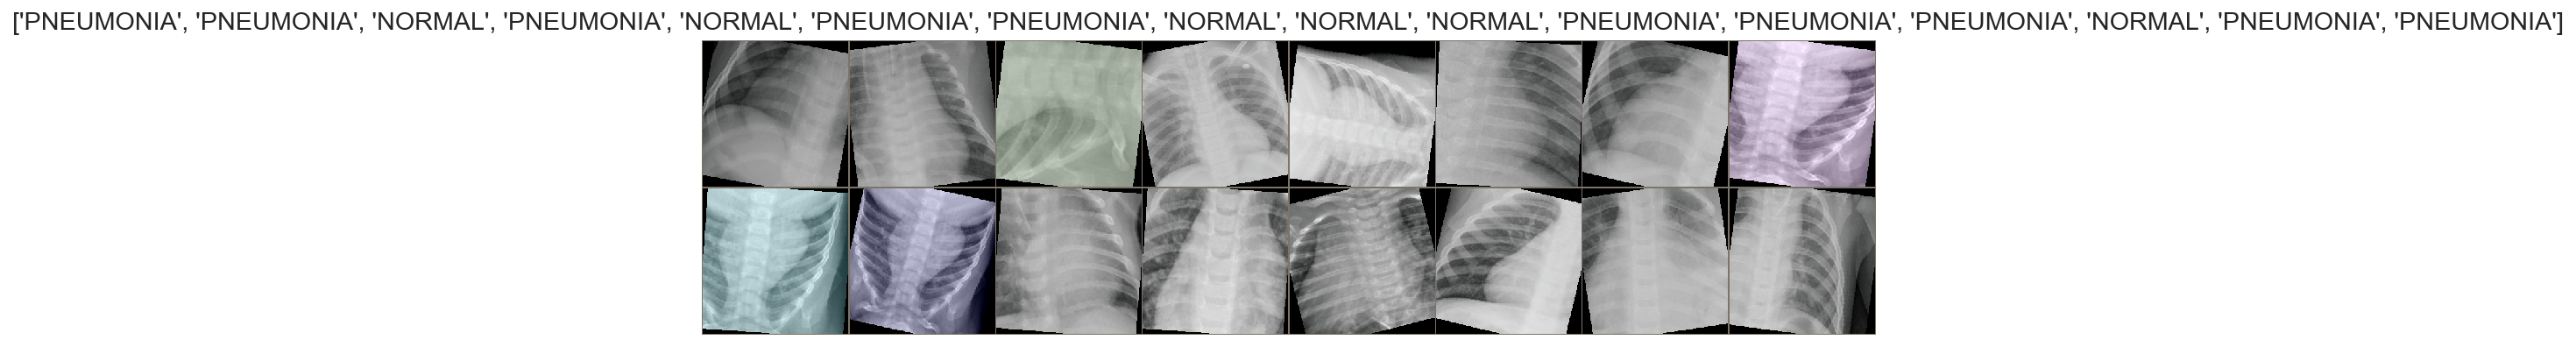

In [229]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Using RESNET Pretrained Model

In [230]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)

    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_features, n_classes),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [237]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/serdar/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100.0%


### Model Training

In [231]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples):

    model = model.train()

    losses = []
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels= labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1) # o satirdaki en buyuk degeri prediction olarak aliyoruz, yani predicted classi buluyoruz
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds==labels)
        losses.append(loss.item())

        # ALTTAKI UPDATE'LER SADECE TRAIN PHASEDE
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [232]:
def evaluate_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples):

    model = model.eval()
    
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [241]:
def train_model(
    model,
    dataloaders,
    dataset_sizes,
    device,
    n_epochs=3):

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch +1}/{n_epochs}')
        print('-' * 33)

        train_acc, train_loss = train_epoch(
                                model,
                                dataloaders['train'],
                                loss_fn,
                                optimizer,
                                device,
                                scheduler,
                                dataset_sizes['train'])
        
        print(f'[INFO] Train Loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = evaluate_model(
            model,
            dataloaders['val'],
            loss_fn,
            device,
            dataset_sizes['val'])
        
        print(f'[INFO] Validation Loss {val_loss} accuracy {val_acc}')

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
        
    print(f'[INFO] Best Val Acc : {best_accuracy}' )

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [234]:
def get_predictions(model, data_loader):

    model = model.eval()
    predictions = []
    real_values = [] 

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [235]:
def show_predictions(model, class_names, n_images=6):

    model = model.eval()
    images_handled = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)

            for j in range(inputs.shape[0]):
                images_handled += 1 
                ax = plt.subplot(2, n_images//2, images_handled)
                ax.set_title(f'predicted :  {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handled == n_images:
                    return

In [242]:
%%time
base_model, history = train_model(base_model, dataloaders, dataset_sizes, device)

Epoch 1/3
---------------------------------
[INFO] Train Loss 0.38258605107818683 accuracy 0.9303225806451613
[INFO] Validation Loss 0.5394803881645203 accuracy 0.6875
Epoch 2/3
---------------------------------
[INFO] Train Loss 0.3756385841934951 accuracy 0.9365161290322581
[INFO] Validation Loss 0.6311467885971069 accuracy 0.6875
Epoch 3/3
---------------------------------
[INFO] Train Loss 0.3677541726643277 accuracy 0.943741935483871
[INFO] Validation Loss 0.6356928944587708 accuracy 0.6875
[INFO] Best Val Acc : 0.6875
CPU times: user 2h 48min 4s, sys: 5min 45s, total: 2h 53min 50s
Wall time: 2h 54min 16s


In [243]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()

    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')

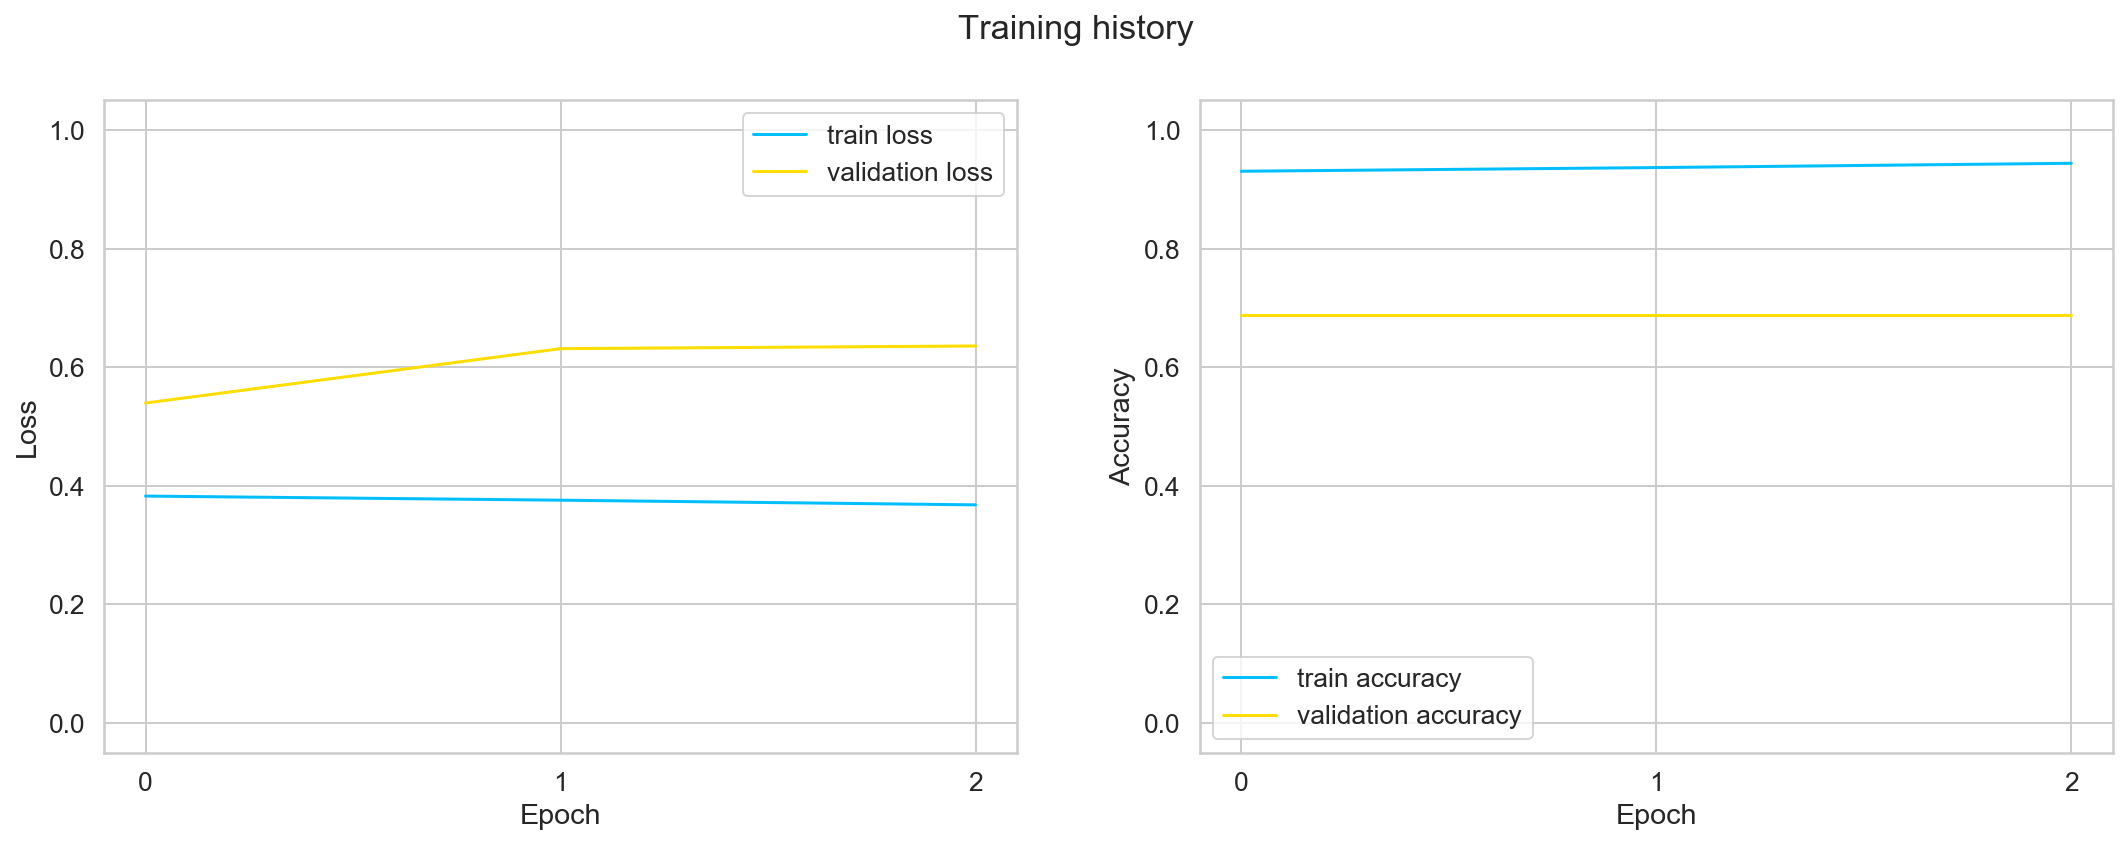

In [244]:
plot_training_history(history)